<div style="text-align: right"><sub>This notebook is distributed under the <a href="https://creativecommons.org/licenses/by-sa/4.0/" target="_blank">Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license</a>.</sub></div>
<h1>Hands on Machine Learning  <span style="font-size:10px;"><i>by <a href="https://webgrec.ub.edu/webpages/000004/cat/dmaluenda.ub.edu.html" target="_blank">David Maluenda</a></i></span></h1>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://atenea.upc.edu/course/view.php?id=71605" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/upc_logo_49px.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/dmaluenda/hands_on_machine_learning/blob/master/02_Training.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/dmaluenda/hands_on_machine_learning/blob/master/02_Training.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/02_Training.ipynb"  target="_blank"
          download="02_Training">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

# $\text{II}$. Training Neural Networks with Pure Python

Hands on "Machine Learning on Classical and Quantum data" course of
[Master in Photonics - PHOTONICS BCN](https://photonics.masters.upc.edu/en/general-information)
[[UPC](https://photonics.masters.upc.edu/en) +
[UB](https://www.ub.edu/web/ub/en/estudis/oferta_formativa/master_universitari/fitxa/P/M0D0H/index.html?) +
[UAB](https://www.uab.cat/en/uab-official-masters-degrees-study-guides/) +
[ICFO](https://www.icfo.eu/lang/studies/master-studies)].

Tutorial 2

This notebook shows how to:
- understand the cost function concept
- implement a stochastic gradient descent to fit an arbitrary function
- implement backpropagation in pure python
- train a deep fully connected net to reproduce an image
- differentiate 'hyperparameters' from 'parameters'
- choose a learning rate
- choose a batch size
- differentiate training, validation and test datasets
- initialize a neural network
- save and load networks
- interpret the 'epochs' concept

**References**:

[1] [Machine Learning for Physicists](https://machine-learning-for-physicists.org/) by Florian Marquardt.
<br>
[2] [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html): the fundamental package for scientific computing in Python.
<br>
[3] [Matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html): a comprehensive library for creating static, animated, and interactive visualizations in Python.<br>
[4] "Back-Propagation is very simple. Who made it Complicated?", Prakash Jay at [medium](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c).
<br>
[5] ["A Step by Step Backpropagation Example"](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/), Matt Mazur.
<br>
[6] [Backpropagation Step by Step](https://hmkcode.com/ai/backpropagation-step-by-step) from hmkcode.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0.-Imports:-only-numpy-and-matplotlib" data-toc-modified-id="0.-Imports:-only-numpy-and-matplotlib-0">0. Imports: only numpy and matplotlib</a></span></li><li><span><a href="#1.-Curve-fitting-(base-for-training)" data-toc-modified-id="1.-Curve-fitting-(base-for-training)-1">1. Curve fitting (base for training)</a></span><ul class="toc-item"><li><span><a href="#1.1-Function-definition-and-model-fitting" data-toc-modified-id="1.1-Function-definition-and-model-fitting-1.1">1.1 Function definition and model fitting</a></span></li><li><span><a href="#1.2-Cost-function-(loss-function)" data-toc-modified-id="1.2-Cost-function-(loss-function)-1.2">1.2 Cost function (loss function)</a></span></li><li><span><a href="#1.3-Stochastic-gradient-descent" data-toc-modified-id="1.3-Stochastic-gradient-descent-1.3">1.3 Stochastic gradient descent</a></span></li><li><span><a href="#1.4-[EXERCISE]:-Your-own-examples" data-toc-modified-id="1.4-[EXERCISE]:-Your-own-examples-1.4">1.4 [EXERCISE]: Your own examples</a></span></li></ul></li><li><span><a href="#2.-Backpropagation" data-toc-modified-id="2.-Backpropagation-2">2. Backpropagation</a></span><ul class="toc-item"><li><span><a href="#2.1-Implement-of-backpropagation-for-a-general-(fully-connected)-network" data-toc-modified-id="2.1-Implement-of-backpropagation-for-a-general-(fully-connected)-network-2.1">2.1 Implement of backpropagation for a general (fully connected) network</a></span></li><li><span><a href="#2.2-Train-a-net-on-one-single-batch-repeatedly-(not-so-good)" data-toc-modified-id="2.2-Train-a-net-on-one-single-batch-repeatedly-(not-so-good)-2.2">2.2 Train a net on one single batch repeatedly (not so good)</a></span></li><li><span><a href="#2.3-Train-a-net-on-batches-to-fit-a-2D-function" data-toc-modified-id="2.3-Train-a-net-on-batches-to-fit-a-2D-function-2.3">2.3 Train a net on batches to fit a 2D function</a></span></li></ul></li><li><span><a href="#3.-Train-a-net-to-reproduce-an-image" data-toc-modified-id="3.-Train-a-net-to-reproduce-an-image-3">3. Train a net to reproduce an image</a></span><ul class="toc-item"><li><span><a href="#3.1-Taking-an-image-and-converting-it-to-a-function" data-toc-modified-id="3.1-Taking-an-image-and-converting-it-to-a-function-3.1">3.1 Taking an image and converting it to a function</a></span></li><li><span><a href="#3.2-Batches-generator" data-toc-modified-id="3.2-Batches-generator-3.2">3.2 Batches generator</a></span></li><li><span><a href="#3.3-Model-initialization" data-toc-modified-id="3.3-Model-initialization-3.3">3.3 Model initialization</a></span></li><li><span><a href="#3.4-Model-training" data-toc-modified-id="3.4-Model-training-3.4">3.4 Model training</a></span><ul class="toc-item"><li><span><a href="#[EXERCISE]:-find-better-hyper-parameters--like-learning-rate-and/or-batchsize-to-reduce-the-number-of-samples-and/or-time-needed-(look-on-the-exercise-below-to-do-both-at-once)." data-toc-modified-id="[EXERCISE]:-find-better-hyper-parameters--like-learning-rate-and/or-batchsize-to-reduce-the-number-of-samples-and/or-time-needed-(look-on-the-exercise-below-to-do-both-at-once).-3.4.1">[EXERCISE]: find better hyper-parameters  like learning rate and/or batchsize to reduce the number of samples and/or time needed (look on the exercise below to do both at once).</a></span></li></ul></li><li><span><a href="#Save-and-load-a-model" data-toc-modified-id="Save-and-load-a-model-3.5">Save and load a model</a></span><ul class="toc-item"><li><span><a href="#3.4.4-[EXERCISE]:-find-better-hyper-parameters-for-layerSizes-to-reduce-the-network-model-size,-i.e.-the-02_Network_Smiley.npy-size-in-KB,-keeping-a-reasonable-good-looking-of-the-image." data-toc-modified-id="3.4.4-[EXERCISE]:-find-better-hyper-parameters-for-layerSizes-to-reduce-the-network-model-size,-i.e.-the-02_Network_Smiley.npy-size-in-KB,-keeping-a-reasonable-good-looking-of-the-image.-3.5.1">3.4.4 [EXERCISE]: find better hyper parameters for layerSizes to reduce the network model size, i.e. the 02_Network_Smiley.npy size in KB, keeping a reasonable good looking of the image.</a></span></li></ul></li><li><span><a href="#3.6-Inside-a-network" data-toc-modified-id="3.6-Inside-a-network-3.6">3.6 Inside a network</a></span></li></ul></li><li><span><a href="#4.-Play-with-https://playground.tensorflow.org" data-toc-modified-id="4.-Play-with-https://playground.tensorflow.org-4">4. Play with <a href="https://playground.tensorflow.org" rel="nofollow" target="_blank">https://playground.tensorflow.org</a></a></span></li></ul></div>

## 0. Imports: only numpy and matplotlib

In [1]:
import os

# get the "numpy" library for linear algebra
import numpy as np

# get "matplotlib" for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300  # highres display
from matplotlib.axes._axes import _log as mpl_ax_logger
mpl_ax_logger.setLevel('ERROR')  # ignore warnings


# for nice inset colorbars:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# time control to count it and manage it
from time import time, sleep

# For simple animation
from IPython.display import clear_output

## 1. Curve fitting (base for training)

This section shows how stochastic gradient descent can help to fit an arbitrary function to a certain dataset (neural networks essentially do that, but in much higher dimensions and with many more parameters).

### 1.1 Function definition and model fitting

Let's define a non linear function to fit, for instance

$$f(x) = \frac{\theta_0}{(x - \theta_1)^2 + 1}$$

where $\theta_0$ and $\theta_1$ are the free parameters to fit.

In [3]:
def f(theta, x):
    """ theta is a list of parameters
        x is an array of the input values
    """
    return theta[0] / ( (x-theta[1])**2 + 1.0 )

Let's define a certain target functions (ground truth) by selecting some values fot $\theta_0$ amd $\theta_1$. This two values are the target to be estimated

In [4]:
def get_ground_truth(x):
    """ returns the expected value for a certain x
        (x can be an array)
    """
    return f([3.0, 0.5], x)  # true_thetas = [3.0, 0.5]

Let's initialize our fitting by taking arbitrary parameters

In [5]:
fit_thetas = [0.5, 1.8]  # random

Let's define a function to get random samples of $x$ values

In [6]:
def samples(nsamples, width=2.0):
    """ returns an array of nsamples values, mostly from -width to width.
    """
    return width * np.random.randn(nsamples)

Let's illustrate the parametrized function at some sampled points to compare against actual function

In [7]:
def plot_curves(x, fit_thetas, legend=True, ax=None):
    ax = plt.gca() if ax==None else ax
  
    true_points = get_ground_truth(x)
    fit_points = f(fit_thetas, x)

    ax1 = ax.scatter(x, true_points, color="blue", label='ground truth')
    ax2 = ax.scatter(x, fit_points, color="orange", label='fitting')
    ax3 = ax.plot([x, x], [true_points, fit_points], 'y:', linewidth=1, 
                  label='deviation')
    
    if legend:
        ax.legend(handles=[ax1, ax2, ax3[0]], loc='upper left', fontsize=6)
    ax.set_xlim(-4,4)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    
    try:
        x_line = np.linspace(-4, 4, 300)  # many values to plot a line
        ax.plot(x_line, get_ground_truth(x_line), color="blue")
        ax.plot(x_line, f(fit_thetas, x_line), color="orange")
    except:  # if f is not analitical, there is no chance to draw a line
        pass

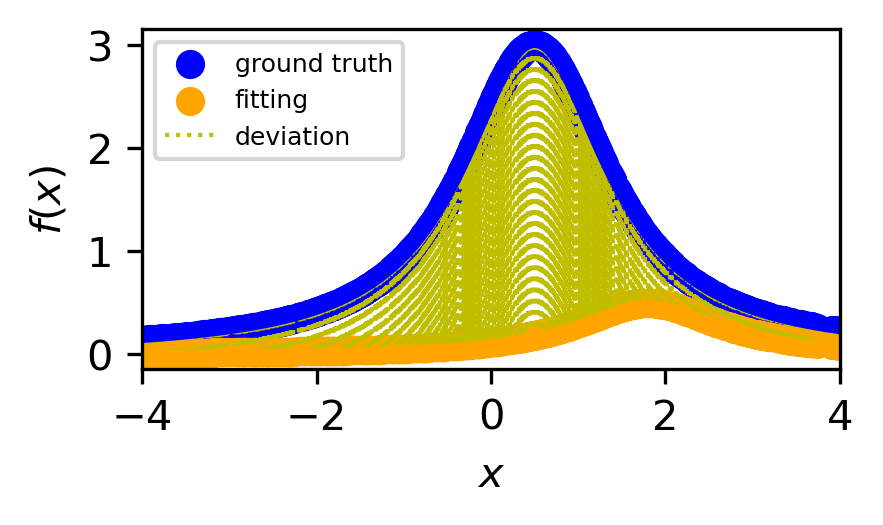

In [40]:
x = samples(1000)

plt.figure(figsize=(3, 1.5))
plot_curves(x, fit_thetas)

### 1.2 Cost function (loss function)

We have to know how good or bad is our fitting by defining a cost function.  We will use the most simple cost function: the square of the discrepancy between the obtaining value with the ground truth value. To sum up in a single value, we will check the average cost function or mean squared error (MSE).

$$C(\theta_0, \theta_1) = \frac{1}{2} \left\langle \left[ f_{\theta_0, \theta_1}(x) - f_{\rm truth}(x)\right]^2 \right\rangle$$

> the $1/2$ factor is just to make things easier when deriving that cost function

[Check this to see more cost/loss functions](https://www.section.io/engineering-education/understanding-loss-functions-in-machine-learning/) (loss and cost functions are basically the same).

Indeed, we will need the derivative of the cost function to implement the gradient descent.

In [22]:
def get_dcost(estimated_thetas, x):
    """ Returns the cost-function's derivative
    """
    f_fit = f(estimated_thetas, x)
    f_true = get_ground_truth(x)
    return f_fit - f_true

def get_avg_cost(estimated_thetas, x):
    """ Retunrs the average of the cost function over a set of samples x
    """
    # we calculate the cost from its derivative to save time
    cost = get_dcost(estimated_thetas, x)**2  # this is 2 time the cost

    return 0.5 * np.average( cost )

Usually the cost is calculated just for validation purposes. For fitting purposes, we only deal with its derivative, as we will see. 

However, let's get a landscape of the averaged cost function to see its behavior

In [23]:
def get_landscape(x):
    """ returns the cost function associated to a set of thetas
        returns also the thetas arrays
    """
    # The landscape is on thetas, WHY?
    theta0s = np.linspace(-3, 6, 40)  # exploring from -3 to 6 for th0 (40 samples)
    theta1s = np.linspace(-2, 3, 40)  # exploring from -2 to 3 for th1 (40 samples)

    landscape = np.zeros([len(theta0s), len(theta1s)])  # init landscape
    for j0, th0 in enumerate(theta0s):
        for j1, th1 in enumerate(theta1s):
            landscape[j0, j1] = get_avg_cost([th0, th1], x)
            
    return landscape, theta0s, theta1s

Let's see how the cost-landscape looks like with the `imshow` function

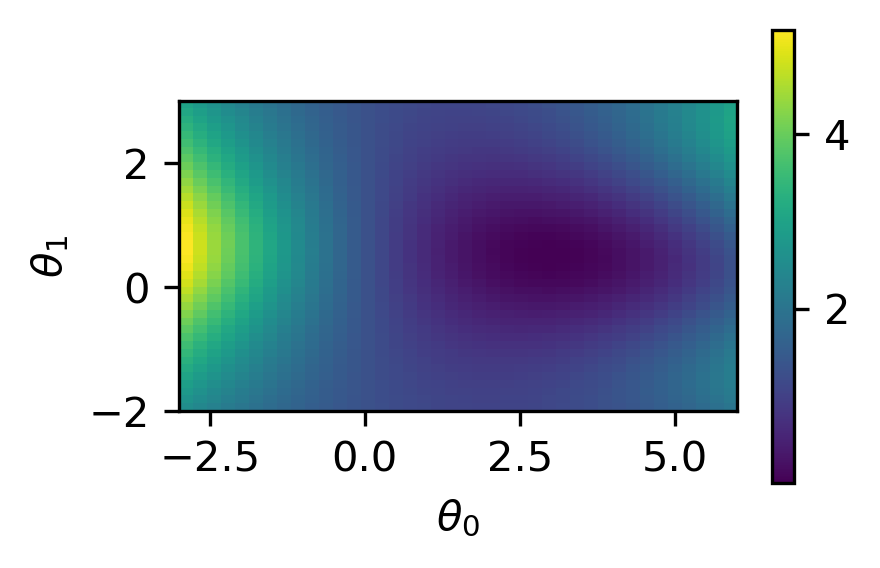

10


In [39]:
number_samples = 1000

for n in range(10):
    sleep(0.5)
    x = samples(number_samples)  # we generate a random sampling for X
    cost, th0s, th1s = get_landscape(x)
    clear_output(wait=True)
    plt.figure(figsize=(3, 2))
    plt.imshow(np.transpose(cost), extent=[th0s[0], th0s[-1], th1s[0], th1s[-1]])
    plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.show()
    print(n+1)

Why is the landscape changing? What does landscape represent?

Let's plot it more fancy with `contour` and `contourf` functions

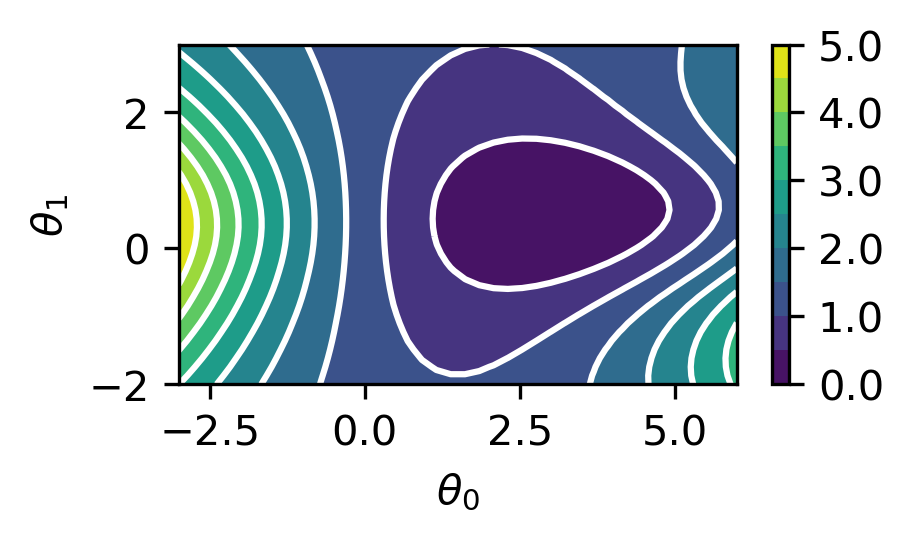

In [44]:
def plot_landscape(x, ax=None):
    ax = plt.gca() if ax==None else ax
    
    cost_landscape, th0s, th1s = get_landscape(x)
    
    nlevels = 10  # number of isolines to be plotted
    X,Y = np.meshgrid(th0s, th1s, indexing='ij')

    im = ax.contourf(X, Y, cost_landscape, nlevels)
    cb = plt.colorbar(im, ax=ax)
    try:  # try to show just one decimal in the colorbar
        cb.set_ticklabels([("%.1f" % i) for i in cb.get_ticks()])
    except:  # sometime it's not possible
        pass
    ax.contour(X, Y, cost_landscape, nlevels, colors="white")  # isolines highlighting
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')

x = samples(1000)
plt.figure(figsize=(3, 1.5))
plot_landscape(x)

### 1.3 Stochastic gradient descent

The gradient descent algorithm is based on walking to the minimum cost function by means of making steps following the gradient of that cost-function landscape.
Notice that gradient is a vector, which components are the partial derivatives respect to each trainable parameter.

\begin{equation}  \label{eq:gradient}
\vec{\nabla} f(x) = \left( \frac{\partial f(x)}{\partial \, \theta_0} \; , \;  \dots \; , \; \frac{\partial f(x)}{\partial \, \theta_i} \; , \; \dots \; , \; \frac{\partial f(x)}{\partial \, \theta_N} \right)
\end{equation}

where $f(x)$ depends on different parameters $\theta_i$ ; ($i=0\dots N$).

In this particular case

$$\vec{\nabla} f(x) = \left( \frac{1}{(x - \theta_1)^2 + 1} \; , \; \frac{+2(x-\theta_1)\theta_0}{\left[(x-\theta_1)^2+1\right]^2}  \right)$$

In [45]:
def f_grad(thetas, x):
    """ thetas is an array containing the values for the parameters
        x is an array of samples where to evaluate the gradient
    
        Return the gradient of f with respect to theta parameters.
        This is a vector of length equal to the number of
        thetas parameters and evaluated on the x samples,
        resulting on a matrix of shape (n_thetas, n_samples)
    """
    df_dt0 = 1./ ( (x-thetas[1])**2 + 1.0)  # partial derivative respect to theta0
    df_dt1 = 2 * (x-thetas[1]) * thetas[0] / ( (x-thetas[1])**2 + 1.0 )**2  # to th1
    
    return np.array([df_dt0, df_dt1])

Remember that one step on the stochastic gradient descent is

$$\theta_i^{\text{new}} = \theta_i - \eta \, \frac{\partial \hat{C}}{\partial \theta_i} = 
             \theta_i - \eta \, \frac{\partial \hat{C}}{\partial f(x)} \, \frac{\partial f(x)}{\partial \theta_i} = 
             \theta_i - \eta \, \left[ f_{\theta_0, \theta_1}(x) - f_{\rm truth}(x)\right] \, \frac{\partial f(x)}{\partial \theta_i}
\quad ; \quad (i=0,1)$$

where $\eta$ is the learning rate and $\frac{\partial f(x)}{\partial \theta_i}$ is the $i$-th component of the gradient, see Eq. (\ref{eq:gradient}).

Let's do a gradient descent and plot the (sampled) true function vs. the fitting function, for each step.
In addition, we plot the current location on the landscape, based on the averaged cost function.

First, let's define a function to plot the progress and, then let's do the train

In [46]:
def plot_info(fit_thetas, stepping, history, nsteps, x, arrows):
    """ This is a funtion to plot the progress on the training.
    """
    
    max_MSE = history.max()*1.1 if history.size>0 else 1  # skipping empty hist.
    
    clear_output(wait=True)
    fig = plt.figure()
    gs = fig.add_gridspec(2,2,hspace=.35, wspace=.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    plot_curves(x, fit_thetas, legend=False, ax=ax1)  # compare fiting with truth
    plot_landscape(x, ax2)  # to see the progress

    # plot where we are on the landscape
    ax2.scatter([fit_thetas[0]], [fit_thetas[1]], color="orange")  
    if arrows:  # where we go
        ax2.arrow(*fit_thetas,*(-stepping), color='yellow',
                    width=0.05, length_includes_head=True)
    
    # let's plot the cost history
    ax3.plot(range(history.size), history, marker='o')
    ax3.set_xlim(0, nsteps-1)
    ax3.set_xticks(range(0, 20, 3))
    ax3.set_ylim(0.0, max_MSE)
    ax3.set_xlabel(r"$step$")
    ax3.set_ylabel(r"$MSE$")
    
    plt.show()

Play with the parameters `eta` and `nsamples`. What do they mean? How does it influence learning progress?

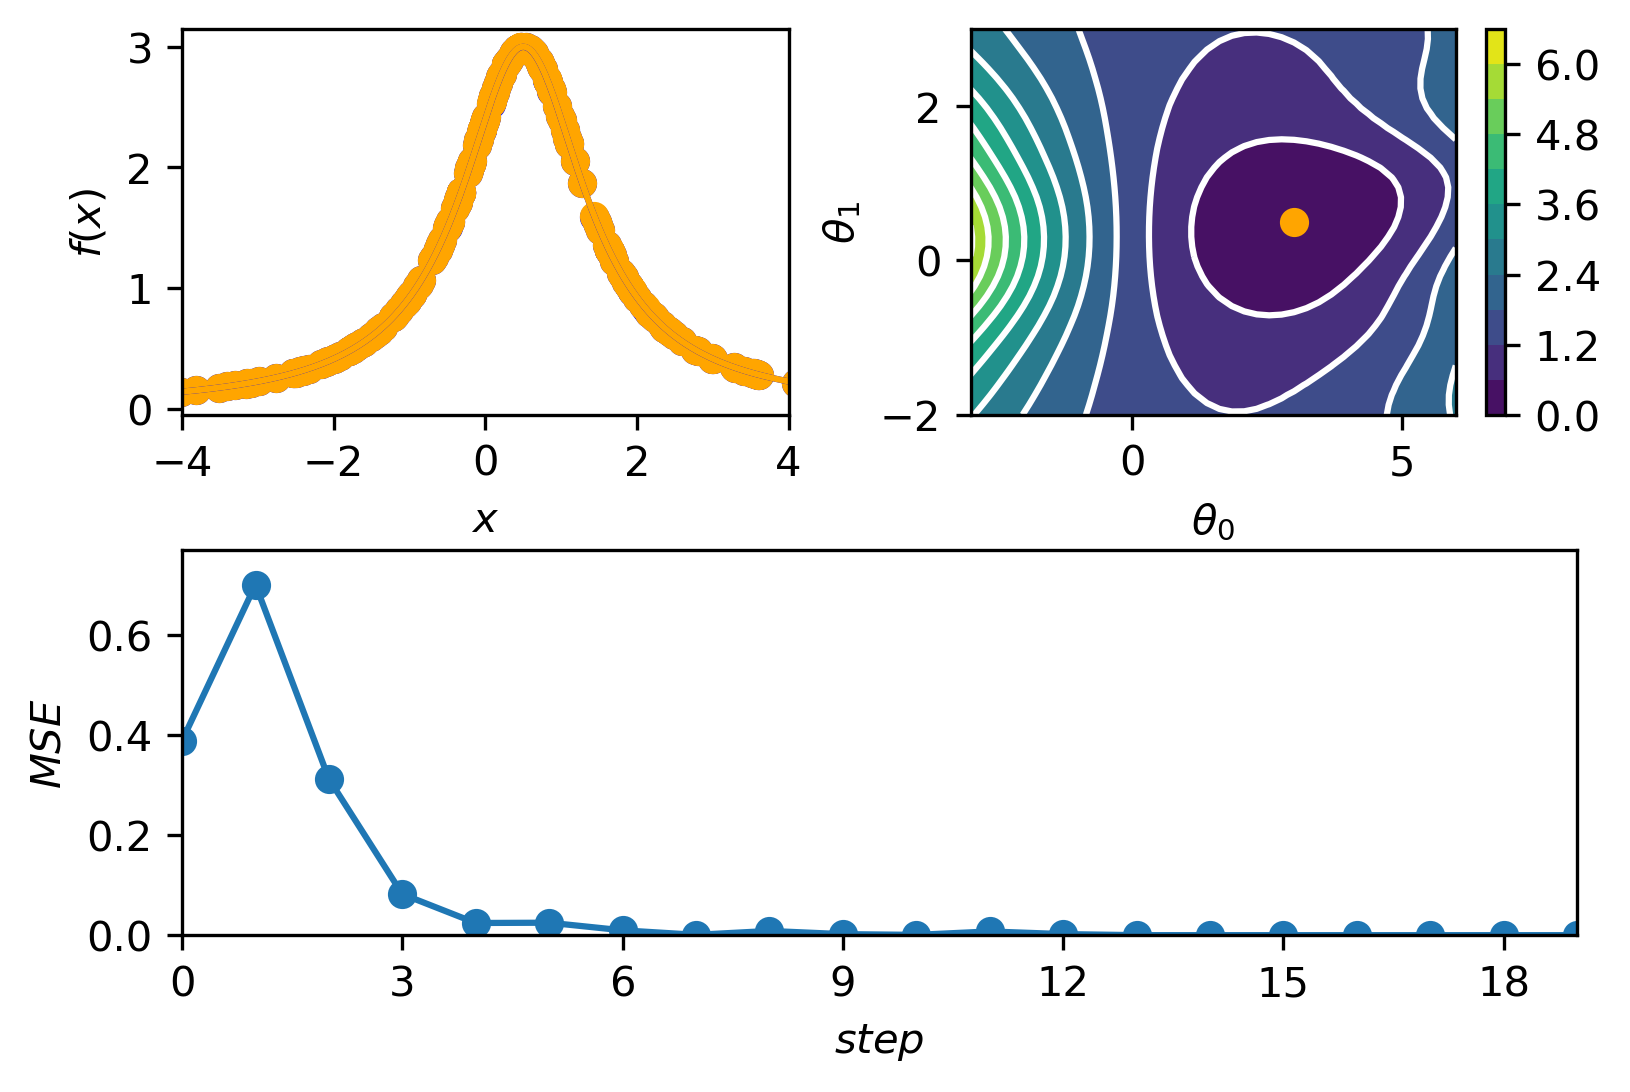

estimated theta: [3.00136977 0.50006956]


In [51]:
def train(eta, nsamples, init_thetas=None, nsteps=20):
    if init_thetas is None:
        global fit_thetas  # let's continue where we was
    else:
        fit_thetas = init_thetas
    nsteps = 20   # steps to do, it can be replaced with a validation criteria

    cost_history = np.zeros(nsteps)
    for n in range(nsteps):  # it can be replaced with a while with some criteria

        x = samples(nsamples)  # get random samples (training set)

        deviation = get_dcost(fit_thetas, x)  # cost for every x (vector)
        deviation = deviation[None, :]  # from row-vector to column-vector

        gradient = f_grad(fit_thetas, x)  # gradient for every x: shape=(2,nsamples)
        descend = np.average(deviation*gradient, axis=1)  # averaging for all x
        grad_descend = eta * descend

        # let's plot where we are and where we go
        plot_info(fit_thetas, grad_descend, cost_history[:n], nsteps, x, True)
        print('estimated theta:', fit_thetas)

        fit_thetas -= grad_descend  # do one gradient descent step:
        cost_history[n] = get_avg_cost(fit_thetas, x)  # stores the cost history

        sleep(1)
        plot_info(fit_thetas, grad_descend, cost_history[:n+1], nsteps, 
                  samples(200), False)
        print('estimated theta:', fit_thetas)

# eta: "learning rate" (gradient descent step size)
# nsamples: stochastic x samples used per step (just a few to be fast)
train(eta=1.25, nsamples=10, init_thetas=[0.5, 1.8])

[Check this to know more on learning rate](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

### 1.4 [EXERCISE]: Your own examples 

Consider a set pairs of $x=$ `x_data` and $y=$ `y_data` to be fitted to the following parametrized function

$$f(x) = cos(\theta_0 x)+ sin(\theta_1 x)$$

1. Plot the data.
1. Override the `samples` function to get a random subset of `x_data` (be careful with the function signature).
1. Override the `get_ground_truth` function to get the `y_data` value corresponding to a certain input subset of `x_data`.
1. Plot the random subset of `x_data` and `y_data` pairs (made by means the `samples` and `get_ground_truth` functions) in the same figure than before.
1. Override the `f` function.
1. Randomly set values for `fit_theta`.
1. Plot the initialized function corresponding to that `fit_theta` values.
1. Run the `plot_landscape` function over the subset of `x_data` values you did via the `samples` function.
1. Override the `f_grad` function.
1. Run the `train` function.

In [ ]:
x_data = np.array([-0.3685229356625121, -0.9574319849938778, 2.3531744582068894, -0.6845548121351077, 2.8557083042825577, -2.232892157410248, -3.5965202833327283, -0.19881834877102383, 0.36817478803432147, -3.3995123449933797, -1.1187028575408453, 0.7341850356749884, 2.0142253894751843, -0.31199624468158965, 1.3222727363042681, -2.1238182951593076, -3.0058151007771894, 0.00665747653447882, -0.4642525570399247, -4.4540139730057495, 0.5687768724419661, -6.546157358984825, 0.6437685587164143, -5.337849705343338, 1.7127926814957528, 0.9120177735711873, 2.27973390993212, 2.4997188336175906, 0.8116375423349206, 0.5015102176277847, 1.4606123049938273, -0.03779344477901791, 2.426488313733847, -0.8273613611097951, 3.742922749567409, -1.6278862821399245, 0.24936021283261886, 2.5485025666726777, -1.4606276332330617, -2.2421379033664106, 1.0674152878193175, 3.219440224432956, 3.6116315248081827, 1.4835129525108095, 1.9476232308869779, -0.4192993080518904, 0.3866004042320523, -1.8914051971269001, -0.3300040353533047, 0.030110215069774095, -1.9525039438642928, 1.2312741018856688, -2.727893213893024, 2.2946617345491447, -1.1950263497911737, -5.623328570942082, 1.0253297264294288, 1.9276751418199767, -1.045601131392798, 4.268234619158922, -0.19369356557013842, 3.5541214819558458, 0.2828881826250964, -5.69689307775054, 0.25174485668776075, 0.8424270717164403, 1.348231246208408, -0.28053176535495905, -1.761293345848571, 2.2270028107988, -0.7350629041497103, -1.3567918438079936, -3.2734390847032344, 0.5564677004023703, 0.8973554079139238, 5.087209386117203, -0.7249391414632872, -1.1687131779910704, 0.8496237858495685, 1.3465553586678765, 0.8108483081414478, -0.3518679966427105, -1.9152883443449977, -2.1182077713729925, -1.1683434880618544, 2.235222769927697, 1.8816895659452793, 2.36382455956848, 0.9597676530743335, -2.8311834626884127, -0.18698196176616796, 1.212766468244503, 3.6043518588951726, 2.686766808753662, 0.19667192575134446, -4.335680841534202, 0.07380909897018595, 0.15648027481323773, 0.7033548490661692, -3.1790784751467194, 2.488033238257813, -4.277247731105709, 4.25829986413777, 0.15072402998262757, 0.23673374936566557, 1.798177409568698, -1.560594580831866, 1.9387895191735531, -0.18810211221079495, -1.6077588521461654, 2.6572040106741714, -0.14893315432028825, 1.4059307234297624, 1.488118709197572, 2.7971429854389984, -0.8040687829362895, -3.481515418628456, 2.6139493141091794, 1.2333383095202266, 0.8638922772625184, 1.4342157745545865, 0.07242029048440567, -1.0960850501384054, -1.0137919370692647, -1.2295649620510607, -1.3225833112635024, -1.958567717351323, -5.208108904792499, -0.6710312211568582, 0.6766426633952431, -1.5150936324126771, -1.3762382017120744, -2.920167844982165, -0.166521693895981, -0.5012142442613876, -2.2963941808432295, -1.116479350533768, -0.056034648705997114, 3.3166333751989687, 3.2332426946571813, 0.10275603493937586, -0.15796231147975245, 1.9831416513022182, -3.076908783357059, -3.3850074610012557, -0.2088794878473252, -1.899186906579945, 0.6777146893927005, -1.8052671474953441, 2.4776287534133847, 1.3180890776947976, 2.0122940541760492, 3.654044072026736, -1.9692218048509147, 3.4515310878501095, 0.14136997154747183, -1.0948753173396224, 0.9303048126188901, -0.25013462910574513, 0.2030002327119878, -0.8185767006078466, 2.6504489044140014, -1.9207478516927885, -0.002765654143088911, -2.191589740890703, 0.5280399002342153, 0.44095936277654085, -1.2659366597385109, 1.2943343635082611, -2.2607762580173167, 0.5296470177531093, -0.33324011485934935, -0.1360135070256781, 0.7132952473633865, 1.0890161429549603, 0.18990490174755367, 0.6990554217918029, -1.0748995141920688, 0.7503193053649452, -0.14437849097466812, 1.106924255148534, 1.9527838921246647, 1.2280652024300953, 2.716473405831393, 1.0372542081809342, -1.9555244594572705, -4.616884058746333, -0.21324148436319817, -1.4974056164804541, 0.42777497765755634, -0.9609110760395687, 0.5310482110553224, 0.011706714617503665, 1.6777510829372528, -2.197777774853208, -2.760736750304859, -1.861422660519576, 0.5689604085226463, -1.2228210577348486, -0.6240770138687503, -1.931567953472427, 3.2238224718370145, -1.1618557210339775, -3.0813008077765724, 1.2201506376275102, 1.9834723722521883, 0.29838793195400537, 1.7638276638025336, -1.2406679174498751, 0.8822582035936454, -1.1217653607268059, -0.882166335160103, -1.6921135207905917, 1.503403845070189, -0.3966813580353098, 2.7827851747272967, 0.42510302215831686, -0.49397608630339973, 1.712922245966194, -2.3788183555771285, -0.9715628360094559, -3.3427062058010577, 1.557227637297524, 4.3392564887126115, -3.2067854108938474, 1.2110991833337044, 1.56743420233406, 0.052930707661451804, 0.14315962804343574, -0.7262515955815267, 1.6735848505222595, -1.4044150010432928, 0.3935477758897637, 4.743360192104883, -1.1697214071064177, -1.284538359704915, -0.8448617699724479, 0.6198440599694635, -0.7812612351691387, 1.3488264392555702, -4.788013367372688, 0.8518764396142527, -0.7234511049850648, 1.8415048074724094, -5.043813399309482, -1.2608489702833685, -0.47035124739041984, 1.0954146010769084, 1.636754093080726, 0.6429988568847619, 4.486932411243577, -1.660041702283949, 3.2249571962408594, 1.9982925933715867, -4.542386938945562, -0.2932604117796473, -1.35698385234885, -2.1734262320585045, -0.8316874515860467, 0.19893827345084505, 1.7890297688777959, 2.775117510467724, 1.9285573042502737, -1.0491509559611862, 1.2846020297270857, -0.7967062402143418, 0.42026029583190083, 0.9874639348263986, -0.11285895294687623, -4.054868529655052, 0.2752753250857417, -0.9953679989037805, 0.46249527341030544, 0.27589111441113906, -2.4949448011499156, 0.42055862574428793, -0.17628499224500147, -1.6306542651351381, 0.5909175796573618, -2.8052884317053275, 0.9563372098636186, 1.7159918719517249, -1.303930445530589, -1.3388888024609118, -4.44468702139376, -0.9008833649477346, -3.721374313304611, 1.9744282265027366, -2.152151822244086, -0.060672211012911766, -0.13145952530773106, 0.03627817037343812, 3.28854181993945, 2.5292648004201355, 0.008711672516828934, -0.2529483511230282, -1.254051417237444, -1.3428857541859693, 2.8473350984559653, 1.7872043249178042, -3.2477671382348996, -1.9482932950066598, -0.5254005723209054, -2.719752318301928, -4.219486737579441, 0.03358091931868104, -1.2745553109925183, 2.2829927017274443, 0.9036754388347169, -0.41827831338188415, 1.4322375007290427, 4.2144817162468176, -1.743641766221133, 0.9028524254322388, 2.377011082553693, -0.5949664675289267, 0.07792834250588676, 2.729146271881642, -2.628761647917735, 1.1120499976445468, 0.13850932397018037, 1.2882384277826275, 2.2101310948486397, -3.4435857822865956, -0.05196985753343941, -0.8302789823435146, -1.1847538013603203, 1.0013409575703565, 1.0927869339746217, 0.4910829359567506, 1.3708603068895948, 2.5562103088348818, 0.6430180089924304, 0.25220429976823755, -0.9220340324904319, 0.7758370867005577, 2.109599567024931, 0.16159548764098527, -1.7583534577791247, -0.030222248504269474, -0.8588967862372037, -2.5314191028350495, -1.6450986216634431, -0.2646338905742809, 0.7038461257218475, 3.149621906904487, 0.7504649882807976, -0.18407987269645365, -0.9539581987620129, 1.8488327480556026, 0.9097311948777177, -4.115020362821171, -0.10890032129690894, 0.3276409943019973, 1.7578678334846207, -0.48661930332707964, 2.577699973399827, 1.2354277240148508, 0.49991428814601496, -1.9143648263479702, 2.117230519188045, -1.1050574261531974, -1.922079763563787, -1.370255382203265, -4.24702262864514, 0.16982509497642787, -2.3043702640944908, 2.118500814660222, -1.277439633942159, 0.7860394536677212, -0.8228451248136912, 2.1147038315525557, 6.465090311355353, -0.6015736832278538, 3.3754587167020094, 2.033338148507915, -0.5351336110405682, 1.1342876139059057, -0.9298637128333559, 1.8180564349893553, -2.0177622036150993, 1.2862263253500124, 3.122637240048611, -3.1095111067461203, 0.24289879106764772, -0.6337755993219808, 3.1618328908531037, 0.29362619609034857, 0.6006136026460492, -2.1694320056752607, -2.1154161540336567, 
                   0.6722663987313405, 2.1892341756862397, -0.5907086820858217, -0.30500731288276955, 2.089724649097978, 0.07494133818917156, -0.4689415193390907, 3.3956682265023437, 0.5520190599629824, 2.836307277573856, 2.2006409761293937, 3.2960015763662414, -0.3048655126053833, 1.3174473445116144, 3.2114963977518576, -0.04851842844942595, 0.08818775502164429, 1.0507569730095419, -0.9932291338855532, 1.1737264701678696, -0.4274459509102818, -1.074804093597261, 0.7879593567004579, -3.6604825635185385, 1.1900017602366608, -1.4632396661281168, 1.7078787400802837, -1.1930198938439858, -3.8100776551754034, -1.048770200786205, 0.39114732314314365, -0.49734997991254093, -0.00044872219343894523, -5.678223493500038, -0.15131303808772611, 2.2364542677788504, 4.860304356925433, 0.9291574296239655, 0.6650873567091591, -1.3695616108083308, 0.7083289570128458, 1.920896395547621, 0.06989763792448507, 1.297672961905441, 0.7511802754995602, -1.9839671896604765, -0.6603426088849117, 4.30434955444391, -1.2250800907576882, -2.369114647493412, -1.366592634578551, -2.182732522363731, 1.0685169431359245, 0.16691626290035005, -0.002382130673917725, -2.7242781027002057, -1.480004767265022, -2.681687078834684, 2.4753187856961043, 0.602714507820822, -3.342457072851236, 1.4517472447645192, 0.015462135591340968, 1.4138266444474605, -0.2169278067443094, 0.3221357432142563, -0.8185927870036741, -0.0063468763802284845, -3.3501143576225556, 0.8744991237900838, 1.80865861041253, 2.3144390966529516, -0.6247940095027649, 1.9871582192283583, -1.2261023817247585, 1.3351981759472036, 0.6937190458540021, -3.051988598996005, -4.422345873308539, 0.163443005349257, 0.9459570680074957, -0.2013496523126228, -1.0218440288415467, -1.360283877606575, -1.1489263207190883, 1.9637450536123806, 0.5187027079368063, -2.0725867588174194, -1.367276212462766, 3.373348940180057, 1.0760844360666808, 1.7048225555043293, 1.0639334788102315, 0.9778140988248074, -2.0008451567357364, -1.5561227620646267, 0.3602473231326664, 2.9966210963910656, 0.3187296343544145, 2.2991773907495103, -0.765472035373591, -1.722362252716888, 3.340267791871363, -0.9282157918818497, 1.891751110962881, -0.09167382526451094, -3.211273201740966, -0.8017441996263598, 1.154889313948648, 0.4718482217319951, 1.9217157421856066, 2.5184100648047956, 2.361565707081031, 3.4054634953073055, 4.638157494731892, 1.7572821679326385, -1.2363422616038782, -0.4378166181174846, -0.8099008668632197, 2.4534543321506477, -0.8843070680593702, -2.0397563287150398, -2.109338911961259, -3.4646096553046175, -3.236303518238583, -2.2813395601971904, -0.21408804483983493, 2.291104080467262, 0.21425237326171687, 5.456528450482639, -0.47580357146850794, 0.8113821647588869, -0.9997408318778331, -2.3111166459061114, -1.0231971035653025, 4.170074742285567, -1.9443318449369553, -0.609010074453474, 0.2497806708454733, -2.409477487141811, 2.6101086795510846, 2.6981967046624544, 0.03703608909540514, -0.6675875546810272, 1.533704095902382, -0.4511274956077742, 0.9161052453497333, 2.971150126444798, 0.5245531267700684, -1.001734172357785, -0.5595137356222168, -1.4345346996483208, 1.267326665961272, -3.863212260716629, 4.359352187242002, 2.1990346131944816, -0.22284230431473923, -0.4234845607927287, 1.8432463562158274, 0.45725287719971514, 0.1662775706517423, -3.0865642377040183, -0.9186850961387201, 3.7225986995682723, 1.9105935291841345, 0.5377183270278261, -2.4579170486831328, 2.3879856920479594, 1.89077820395461, 1.1247589519592556, -0.3873778021952155, -0.1293004026107621, -0.6407774516954968, 0.8409905828243834, -1.2927123234689752, 0.16222894765845539, 1.4571080288940028, -2.1155911200587867, 0.4848458725031721, -0.3345484563904057, 5.78954868918608, 2.5919925223220934, -1.2052087447326587, -1.645193251403556, 0.518099075849249, 0.7491378976753045, -0.4668979903683389, 3.0998704598914726, -1.11836951816328, -2.663938026791262, 0.6671117251617635, -1.4704862919468407, 1.7809921501021546, 0.1390970162719878, -0.7104164937609924, -1.7075064443343446, -2.2099723471418318, -3.001865485454449, -0.3239892530715101, -1.0115424017076353, 1.5238302046051428, 0.9143934556774916, 0.23049854208774956, 4.4600138292649785, 1.1575862356957274, -3.28734115406999, -0.37323996794184255, 0.993968366010511, -2.1587721550468255, 3.489148876242809, 2.8088133949131207, 0.32386865908435386, -0.2855569301754996, 0.8365410086016123, 3.072979800536343, 3.0399509941117966, 2.5252569555995743, -0.6557570341049924, 0.7750411782357841, -2.14511825604591, 1.4855054435015316, -3.1608714183040303, -2.476117462136894, -0.0473553174926699, 1.0742886535392047, -0.41472600790655384, 1.9561076265269084, -2.191485605868468, 1.9312029215853146, 0.24769826447171692, -0.0036468636414372702, 2.269466040609702, 0.7641491141264852, -0.3335287567809897, 0.26906172724552413, -4.14588338406018, 2.0164535956615404, 0.4306586836537558, -0.17199444635237396, -1.1504075528990536, 1.5407136523687772, 0.6649607434526082, 0.1696668030549995, -3.08701694264999, -2.444175667211704, -2.5853373045665955, -1.001204695124435, 0.3152470185735821, -1.5909104735459134, -2.4636143741247087, -0.5576663592400225, -1.8891726680824414, 0.979637206271421, -3.8096491801702888, 1.5939249689818453, -1.2177363672004706, 1.4638319779138755, -0.6484425847656264, 3.2057093245373376, -0.5871655381595231, 1.6332466506156427, -1.1830030772431641, -0.2880623881796151, 6.052077913745263, -1.8082570127926936, -1.832950370715091, 0.4832821478687907, -3.4737114570602925, -1.2977913657602844, -1.7203428467973776, 1.9773202343927927, 0.15486342508154988, 1.4839827282651652, 3.6461311091151063, 0.0936579021228924, -0.5805507858477327, 1.8741555015775024, -1.4515034598076957, 1.86796810581688, -2.3562376984077473, 1.1285590711858127, 0.4592357470311912, -2.02982653121302, -1.71068707053063, -3.3423008574448625, 2.7597200222170883, 1.5376989991768428, 2.047850812713121, -0.4806513728002033, 1.2347677375466695, 1.0063386417529414, -2.5081500905086704, -2.4494280327241733, -2.5642838976600206, -3.6336586273153593, -3.7647567846177745, 4.157809546484552, -0.5289506230034721, 1.1522482777096925, 0.8867703792296158, 1.8588598986598577, -0.07196445669407382, -0.32976423434094887, -2.5926373557838716, 1.1325568142554694, 1.0198988484096496, -2.936080121109602, 2.3108317939086693, -1.0158427900169518, -2.503696680309771, -1.9972480803769883, 2.5010229984189714, 2.68862534608968, 1.2595018020611628, -1.8887139785662448, 1.6113439578710604, -1.7433967087855877, -1.6877056493696374, 1.0076662629162645, -2.781652980646511, -0.8379347318106419, -0.936522709513047, 3.4656000938872724, 2.7253042025335605, -3.3856227586846117, 0.6915184302774262, -1.2789516145462003, 2.4997555397808795, -1.7662263918251484, -1.6614925274080135, -0.5199316539022404, 3.7339428363514737, -0.7126149465906194, 1.4461955562608038, -0.6491731870364468, -1.351752023403481, 0.6896850219424867, 0.6838315774379, -0.35378979079155465, -0.6399846320201914, -0.15484173034679852, -0.6331266207115007, -0.6795306275848815, 0.0033221064917282085, -2.962939677814747, 3.4052936692217672, 2.848397297104594, -2.1301394950830255, 2.5564254883365813, -2.6922270642193906, -0.23015369852466472, -1.3890200487496644, 0.13459166329997857, -1.9905122476080628, -1.4208283690044865, -1.6212517314545332, 0.3619645844704976, 1.3962323008511426, -2.284691208301266, 1.8947423790561528, -0.420752141834351, 0.9141191699646763, 0.3561487375357584, -0.11644296869901209, -0.5691198670278688, -0.564500115764094, 0.45190946775922364, 1.9284021068667185, -0.2969814352657103, 1.0277392539103474, 1.5465004525178379, -2.2414101526658756, 2.1805367069895096, 0.25920529604007164, -0.2887898714287073, 5.883876977570589, 2.7220637817788145, 1.7608718522003817, -1.2152542806609103, 0.8357447513443139, -0.7572217153282873, 2.6396637153985667, -1.8134599574756913, 0.8719218184114222, 3.442738906202949, -2.322788174332261, -1.9917427618849475, 0.012373116710210033, -2.969941157271666, -0.6119714961570445, -1.6191123283864277, 3.3515657314942624, 
                   2.455042984474576, -0.6749649047919916, -0.1756438028388296, -1.0477366786090836, -0.852300918917979, -3.5991679388721702, -0.22232513530747902, 2.6053608122600997, 2.50451414830729, 1.2338882789916625, 0.03759623818573467, 0.6372624492714978, 0.146352118869382, 0.32703137947635497, 1.5415653596240082, -1.5465015761405552, -2.3160946932838216, -0.587830842400508, 0.786630195392987, -0.07518169126762297, 0.9713852371194166, -1.7474311045242408, -2.280260933401857, 0.2096198322118077, 0.1574722380602441, 2.0374988702155115, -2.2813527913241938, 0.9212376203119231, -3.714981995711866, 2.666702021815881, 2.7058871370866884, 0.3634102019450128, 0.3335547086058522, 1.0363530744214475, 2.814004237923617, -1.4249568253956477, 0.14796534470263153, 0.44386317204230963, -1.9678190971344307, 2.5102824407720323, -0.5033806400547622, -2.6676882998385167, -1.900056270567025, 1.1155239693159238, 1.0414417253534205, 1.440672191339129, 2.452190543497247, 0.8051902589697638, 2.478126361740177, -1.1008216836635656, -1.6079453097433885, 2.8915902598435412, 1.3598213796173793, 1.2921320852783256, -2.2146708976320473, 0.9882807397417281, -0.944817222834559, 2.3674136603542344, -0.7840238789431467, -1.2290668968336125, 1.8177157676370603, 1.8928792647405062, 1.1734621614473524, -1.0008294726353049, -2.9171143263761175, -1.8221580455722317, -1.0431537775269084, 1.3856927881235892, -2.53175394740923, 1.0120035487989838, -0.2671459323217311, -1.1690291848991918, 5.566580818767595, -1.5473786454969634, 4.954909949392511, 0.5138926598110429, -3.1650152400537785, -3.6236228468490266, -0.31172748911569115, -0.9114012714150806, 0.04175988850044379, 0.11477115033876377, -2.7960333257296353, -0.20316586487102115, 3.2037997562495946, -2.255306637361187, 0.7433003034245536, -2.9308884645308733, -3.6155054573521324, 1.613984676771875, -1.3359738190679378, 0.5716718993803509, -0.9137276016602489, 0.7418784321191425, -0.5881617046594936, -1.3381580641959019, 4.501010841447189, 1.936837269942261, 0.8156451897549657, 0.5086293848701942, 2.805297455498791, 0.311130509361724, -2.687303858693481, 2.0251037284113504, 0.3901075962258487, 1.723519771773529, 1.3519672872387367, 1.364835102208456, -3.2698868352023105, -2.545159883545727, 0.21193362177024158, -1.7277050711814168, -0.8206217331787079, 0.18095916742643964, -1.7612461619710063, -2.2348719233990004, 1.9501842400115552, 0.5434937550660158, 0.03189336541043165, -0.4144102517075362, 0.3686454853141689, 0.028896147438148532, 0.765355096101449, -0.5972174606785501, -2.4145289412214277, 1.1673119190776513, -1.3706135011502354, 1.637616328355282, 0.4432776627914703, -0.04069756764012384, -0.42122673307933045, 0.5598917574421989, 1.269639233463352, -0.3142602113609624, 0.9574014260454612, 1.8025875194808385, 0.7803382332888616, -1.1763107422134693, 0.3766079417021053, 4.127714186167675, -0.024856638774216008, -1.227102156627881, 0.8017732466355924, 0.6816127919995195, 4.507899890337624, 0.5792675016398541, -2.83706723832684, 0.7919726449878078, -5.810639999701223, 0.8469461626943741, -0.0514142505051918, -3.7372606601820424, 2.1997979473195968, -2.8248537439844115, 1.0828633507157073, -0.5579957931282031, -2.7140358153449355, 4.104078188019396, -1.783385055853761, 0.9282632900751372, 4.097432991676601, 1.1782293806396127, 4.694806528708797, 1.3008476897350183, -3.031224716281745, -0.8328270222278221, -2.4808041526940077, -1.4574653843004184, 1.4462545588095799, 0.625234230952996, 1.2422833678647056, -1.1440085112331877, 2.1182414887655456, -0.3928601897264433, 3.4174059813851554, 0.8429315816932664, -1.5800481731162443, -1.775197213612505, 1.2875097292343098, -0.18466888581975446, -3.839021702712769, 0.5354639452559523, -0.16569475421822105, 2.0628750976430603, -1.6769898126171654, -0.4823936242419375, -1.228015160593721, 1.3551205227727352, 1.4890894318143972, 2.013026114007289, 2.384285580070882, 2.6235258194708257, 4.380382004274589, 0.2132126884539087, -1.3031243959623702, -2.2049404070162164, 0.7676006711332484, 0.31022225320095703, 0.06973872225209433, 2.194357071935778, 0.9290597524344116, 3.5048392590610344, -1.76074309230838, -1.2465799746823967, 1.2258873240123151, -0.046543644694832347, 1.8319965895252528, 1.3523208617280686, -0.02741909333531666, -3.9514079952629872, -2.125952440476158, 4.321393527286437, 0.9063316227587142, 0.5227527666042466, -3.091148613435137, -0.60253727697307, -4.619249739442938],
                  dtype='float64')

y_data = np.array([0.45946570720735713, -0.5919376558491583, -0.6841399948281646, -0.1026718118944614, -1.1228581685770747, -1.4174633353856432, 0.8854891182500154, 0.7304587025132049, 1.31520414300509, 0.5174241024534898, -0.857821195617317, 1.3494550291110756, -0.20349713642154343, 0.5531577823307139, 0.8522563134565213, -1.4872914014704302, -0.2719450454913853, 1.007951435009736, 0.2946087076635586, 1.6875273729800664, 1.3696263164492222, -1.6099691690401419, 1.3677124446497149, 0.6704964163468229, 0.27506181549659814, 1.2643827136853243, -0.5893538763570711, -0.852715133603929, 1.3202363431490962, 1.361031381961895, 0.6613448224547827, 0.9534567031923155, -0.7721282533962137, -0.36234640351491376, -0.8228951076006209, -1.4464798478829084, 1.2427026403791197, -0.9020436326304834, -1.3056603268712443, -1.4102781444548667, 1.140407175396507, -1.1637320258510782, -0.9465125508067389, 0.6279650316375693, -0.09938418832630802, 0.3728855223098398, 1.3238001181068186, -1.541387425387319, 0.5236445233094955, 1.0353583962226187, -1.5398180835038886, 0.9657981790400317, -0.7877356954524212, -0.6091235196038427, -0.9734010611405521, 0.0690149871185729, 1.1782518631494656, -0.06786797484875806, -0.7405215504094915, -0.1751438181823327, 0.7381200429057256, -0.9934574729750199, 1.2661203955473237, -0.09213358727630461, 1.244443864313943, 1.3052253160520513, 0.8179891118801033, 0.6039181247010852, -1.5148346440595724, -0.5176117584471505, -0.19492586665628686, -1.19019222614564, 0.26672513597618075, 1.3687838217412542, 1.2737724877286003, 0.7683946552083666, -0.17645054889016443, -0.9344176914592309, 1.301443011461898, 0.8202248759779706, 1.32059601662506, 0.48738498890573256, -1.5418492350994173, -1.490127499755106, -0.9338633116030239, -0.5289835766392983, 0.005205621487509582, -0.6973503112430299, 1.230971805760292, -0.60520411709756, 0.7481017326674257, 0.9875399378620858, -0.9527108954014474, -1.0213929842755607, 1.2013147073076613, 1.6801475233711622, 1.0838553145925007, 1.166055294444843, 1.3576208206144802, 0.07589199841598271, -0.8403711085865544, 1.6629439977019196, -0.18854250425449193, 1.1607491589350145, 1.2332912900346131, 0.13873777723853653, -1.3969023234055633, -0.08544363430276591, 0.7464399281534722, -1.432683184064021, -0.9985189168077865, 0.8035455648459986, 0.7391457111013802, 0.6211990538095401, -1.0934412374058495, -0.32033044602680805, 0.6751464661607947, -0.9624198637310438, 0.9633436544184842, 1.2936402474715503, 0.6992511814690854, 1.0823665032298746, -0.8221696617434127, -0.6877276793321804, -1.0230952477748505, -1.1478832022335743, -1.5391692731930138, 0.917022363248809, -0.07795940877965846, 1.3630769680925943, -1.3579091467148279, -1.2133296687472057, -0.43856141294650736, 0.7781611280975342, 0.22928304537307553, -1.364224376470127, -0.8543432355258987, 0.9301570543152944, -1.1336758116450756, -1.1604862281821067, 1.1140860763424374, 0.790567808898517, -0.1551447913528634, -0.13037561648039742, 0.4890059546186395, 0.7153191758404578, -1.5416892647313192, 1.362887098677787, -1.5283210584695404, -0.8292126360814325, 0.857705018171032, -0.2005064481913632, -0.9089786193523662, -1.537813491346978, -1.065098009935503, 1.1519911943799668, -0.8202460018886204, 1.2520953426281993, 0.6519202850472652, 1.2065781045059847, -0.34652404616582944, -0.9930856730265518, -1.5417611440151842, 0.9966747578554207, -1.4471656033243105, 1.3655880911871956, 1.3449451008658229, -1.073516540969369, 0.8882398610936928, -1.3952034967181348, 1.3658152996044077, 0.5183067034158539, 0.8219159548519741, 1.3552059168043318, 1.1198144772775087, 1.1955990615008458, 1.3586008357214094, -0.7882427342063546, 1.3443894608598486, 0.8100487715370931, 1.1021573354120462, -0.10751581068424865, 0.9696021332658069, -1.0428769881683038, 1.1678395510588613, -1.5395060327888532, 1.6371577498937113, 0.7087153363318708, -1.3415958802929002, 1.3403970954863427, -0.5979268916281941, 1.3660088431487107, 1.0139317928652867, 0.3305848535010587, -1.4429663775421409, -0.731135018615848, -1.538859337719174, 1.3696364050526166, -1.013527768057336, 0.007728255993324384, -1.541373399638142, -1.162738602444965, -0.9241048694866917, -0.12156003308606866, 0.9789230490718328, -0.1556615842433744, 1.2761668847144558, 0.19369214030563486, -1.0386998626153279, 1.283006568821923, -0.8626017257112559, -0.46027862085331583, -1.484464954379505, 0.5986236375331078, 0.41171157345200454, -1.0852853188884604, 1.339429983054913, 0.24213693545248494, 0.2748558993845064, -1.2818798268666807, -0.6162044842161642, 0.4054099602078637, 0.5177578126233624, -0.0792934373191364, 0.13202045535118978, 0.9894748700498397, 0.502203718334642, 1.0611076805924253, 1.1536797286295806, -0.1788463896642828, 0.3371611624616647, -1.2456422625095356, 1.3268540737512227, 0.4358658520271498, -0.935928686210009, -1.0985107070410558, -0.3937723941600201, 1.3696350018878918, -0.2790125959814168, 0.8171943120590703, 1.5103232756219418, 1.3002379463040097, -0.1737339655663549, 0.06938897861234283, 1.1913285672912755, -1.066585568772869, 0.28388556818184674, 1.113565971229694, 0.39501765457572113, 1.3677933674610712, 0.11775000682307035, -1.4666574072193344, -1.162475735974504, -0.17876982305535016, 1.6688700022205125, 0.5835108012548598, -1.1904239610372003, -1.4589768750703405, -0.37012696882503204, 1.2032087709768942, 0.15337989035470856, -1.0807788647901424, -0.06926437117345141, -0.7463511755824548, 0.9005477896589158, -0.30701000751973273, 1.337638198958246, 1.2096483934182507, 0.854239283865089, 1.518537036382644, 1.2610048483226555, -0.6567144612919602, 1.35157112265057, 1.2614230565774243, -1.14194214149016, 1.3377500304339685, 0.7638874036680332, -1.448307322860992, 1.3703193279074477, -0.6521718230637847, 1.2335146384912792, 0.26997617699978116, -1.1239748327878987, -1.1683016650147837, 1.6882898722166684, -0.493362876382046, 1.0947831043690561, -0.14151211074916825, -1.4718297513353498, 0.9241487203175204, 0.8283345923037735, 1.042408151775815, -1.144074379373377, -0.8830212956160925, 1.0103896875073, 0.64752155290582, -1.057262566410321, -1.1732372046822896, -1.119033925811414, 0.156301341458136, 0.2149353596275061, -1.5402161970308068, 0.18613665323375506, -0.8015412462365729, 1.6372766178345066, 1.0393334612416454, -1.0851651816171606, -0.5936906940171525, 1.2697758644253048, 0.3746466719336152, 0.7020663648986856, -0.2475060557110066, -1.5081416874758942, 1.2703006775237466, -0.7135095372564588, 0.060668674088682595, 1.0882506247717076, -1.051578106463561, -0.9492873716352311, 1.0970073555873203, 1.1492795184146891, 0.8959630370404593, -0.4940629424923633, 0.6028651014998117, 0.9353952239409937, -0.367594649325116, -0.958294792882027, 1.1984396718597972, 1.1161402083609873, 1.3588244171449197, 0.7874930255654453, -0.9095051371298066, 1.3677913692593515, 1.2447780162946283, -0.5304893536110046, 1.3352758003793959, -0.34847852677827795, 1.1707170354249223, -1.5137705431996709, 0.9629695409151373, -0.41887590848945355, -1.092585503644996, -1.4575676994878202, 0.6291549374638978, 1.3575063575952109, -1.1748616536699912, 1.3443412551588108, 0.7523994294004033, -0.5859482256919677, 0.057669899719152484, 1.2658742269095145, 1.5695491279166078, 0.859686877333741, 1.2937712367261551, 0.20321620061821888, 0.2551720133724201, -0.9298183693755244, 0.9608531724282889, 1.3607088079041278, -1.5418570057187726, -0.35981730976572324, -0.8363843811907032, -1.5417287091946723, -1.2062831185229528, 1.6505773597127478, 1.1781110077338681, -1.3569006508867065, -0.36170062374693457, -1.0890373148989887, 1.331256640365965, -0.3542158144447818, -0.356067704115303, 0.4721785447445499, 0.048670070324482784, -1.1075020532100692, -0.23298816491979013, 0.16869526289247627, 1.0741775822126371, -0.5441581239043707, 0.10691356684157316, -1.5281562922080996, 0.8985019583352182, -1.176773093278879, -0.06479321797907645, 1.2379267492725776, -0.009947550202294875, -1.1735567333090857, 1.2731332252341037, 1.370290382701974, -1.4614709079674504, -1.491510778902998, 
                   1.3638267537164803, -0.4645211797204146, 0.06839464135537576, 0.5645232086289346, -0.31874892801557797, 1.0850664995953265, 0.2863662997681313, -1.0971627250217963, 1.368398892488631, -1.1138022656428892, -0.4806972513809913, -1.1414472093381018, 0.5647532800294315, 0.8585389440796879, -1.16544459905495, 0.9398222713297995, 1.0990634556056038, 1.1557510921792504, -0.653094465531393, 1.0317910495200566, 0.35880529288780366, -0.7880887983504843, 1.3304764531501923, 0.9955170765232986, 1.0136140110644207, -1.3083010368825738, 0.2828684466457766, -0.9704619782247693, 1.2285688077791903, -0.7457265036688211, 1.325810481174356, 0.23614891767600477, 0.9994613632517914, -0.05119466099009201, 0.8001359511510955, -0.5306814599622722, 0.5636763540200822, 1.2528849684614198, 1.3649686064910056, -1.205461843999431, 1.356438413399384, -0.057130097770728305, 1.0796532892387534, 0.8839903263367194, 1.3441039312224146, -1.5354832873808657, -0.05843344122502314, -0.1263969885164038, -1.0167400788858858, -1.292329554056749, -1.201937508568769, -1.453021298174186, 1.1393758500305018, 1.1755125198208494, 0.9971366520963396, -0.7938775407496164, -1.3249296380246018, -0.8648530247377809, -0.8267140157570965, 1.3702574503975335, 0.4049147684724908, 0.6741452893359983, 1.0183514842911523, 0.728087239461902, 0.7031157191425508, 1.2905943286355583, -0.346553047165179, 0.9923497831700204, 0.42012062242679027, 1.2875796595721434, 0.12195851819127113, -0.6349288348292023, 0.006422079654544555, -0.16141793746580158, -1.0181912980447976, 0.835291598861891, 1.359762958794906, -0.18025883523812852, 1.6891790343996296, 1.1723883607198093, 1.2410756590553196, 0.7266619544707252, -0.7011839658622695, -1.1943965917398218, -0.9044929064462423, -0.12475495397526681, 1.3641576789306329, -1.510402112052302, -1.202750346296579, -1.1085421524726966, 1.1322362859935182, 0.2877206148947872, 1.1436532273682287, 1.217237209680614, -1.532169596729708, -1.3932624772883353, 1.3112845949288174, -1.1678270987362334, 1.2885970912292621, -0.615054776551853, -0.2503247603667549, -1.4991076326651278, -1.1238689459692393, -0.5412847386131541, -0.010824488281184763, 0.8831201056521139, 0.14110917348953955, -0.3161266821712567, 1.0523337067389258, 1.354138001675132, -0.05842868840403381, -0.8720394188289222, -0.6945602524109369, -1.0919078993884306, 0.31059539423899307, 0.2041518806823004, -1.0326422848412302, 0.34081136363775855, -0.3308690862157809, -0.8026860888703462, -0.4640728703797733, -1.5219041885557183, -1.4944579986300512, 0.6430842869087258, 0.1917649704380524, -1.3776638122949785, 0.7074309011129628, -0.6044344355304224, 1.2157408672099845, 0.9508502435037207, 0.27427957723762697, 1.3203528630272579, -0.6641028929289583, -1.3505967057313386, -0.7034391580578373, -0.3069026041686945, -1.5405515287975553, 0.03515281631739908, 1.243010488391737, -1.2475738093802762, -0.9590660259337548, -1.0298386544167284, 1.0432698387023789, -0.07166774126356779, 0.553349365195092, 0.31760581147221256, 1.2616915632485455, -1.1624261640295468, 1.3650759633265583, -0.6674652543142785, 0.12483148211958572, -1.2785518833038245, 0.922096969312727, 1.301928425255988, -0.05221791633692019, -0.4784265225387258, 0.6940959314140025, 0.3656580841778337, 0.06660339486977773, 1.3500500112176357, 1.1749397745316559, -0.11098683231384243, -0.5246302265503777, -0.843423375028562, -0.04078526689656292, 1.3668720331071418, -1.1894715524205333, -0.7267890636111478, -0.009275333507356875, 1.0840562549822588, 0.4275634922279003, 0.8313673631924705, -0.02271776588382035, 1.305967925147236, -1.1093186944593763, 1.1712908268574125, 0.6664130095230993, -1.491424625601312, 1.357392196373258, 0.516145733607767, 0.9382285930157778, -0.9429243747673877, -0.9882292402586359, -1.4576268348274317, 1.364058725570651, 1.3447787546591583, 0.28996016549487336, -1.1773403949153405, -0.8573001728989559, -0.8936489855623445, 1.3646577174591066, -1.3155569231288464, 0.1662418962668255, 1.1498378765713269, -0.14992909039678848, -1.492179224215198, -1.4344315037749622, -0.27973544747550394, 0.533538365543548, -0.6839575477878276, 0.5681761382939058, 1.2628224760469198, 1.2285252081806453, 0.08227883743305664, 1.0494256719893915, 0.29469886631984676, 0.4515133260154814, 1.204437871180665, -1.4679439845230862, -1.0406987496708366, -1.0997981172740288, 1.2916011667047371, 0.59588255717133, 1.3082420377371657, -1.1767731028397987, -1.1742367063650105, -0.8789872514337935, -0.0500590793563499, 1.3355803561215058, -1.4758449864864231, 0.6250401223686417, 0.03901563386569584, -1.1664396179809453, 0.9413098622222085, 1.1339392183241892, 0.3807680304028623, -0.11274793349373113, -1.4472355092175093, -0.07345077124636412, 1.2414823006551408, 0.9956125394456685, -0.5756136392474869, 1.3396171319466383, 0.5178301005355705, 1.2567414727794533, 1.5923595128910408, -0.2069451689230788, 1.341423688294749, 0.7701759790572639, -0.9067506959197864, 0.5427825010391694, 1.364987761208468, 1.1779700261710668, -0.11007701501239253, -1.2064306685404735, -1.0152178558960245, -0.6665724794199619, 1.286529989293057, -1.4204525135207744, -1.1823311812439934, 0.12816334936938945, -1.5412738438338878, 1.215816475733964, 1.2279557826076613, 0.46154339806109046, -1.0062701197888297, 0.6566788139134562, -0.03670527351772679, -1.1666204617764562, 0.07482001830324891, 0.4004985037673766, -0.9557057541262901, 0.5918658539137114, 0.8163925941415555, -1.5290718338071916, -1.5344584289684895, 1.3570199624956134, 0.6603780605203048, -1.1159798283774296, -1.4981957480558257, -0.14604039288595405, 1.1645713021941588, 0.6272757081515552, -0.9161624527588667, 1.1047500049023748, 0.08680587194118239, 0.017221300706814047, -1.2963312081511478, 0.027096325964556578, -1.305889421074986, 1.0801337468090981, 1.350632305971963, -1.5248715119565577, -1.493705401797545, 0.40460424965010744, -1.0714137379027855, 0.5473311982898628, -0.25524668612167845, 0.2657236843706463, 0.9616404940690595, 1.1943182158411982, -1.1243587383240687, -1.1999924372876634, -1.0460364169572622, 0.950052502438029, 1.161904588081911, -0.3232189381455606, 0.17977997544082758, 1.0551706777100431, 1.2802931271652982, 0.04164321983325747, 0.9093769829570312, 0.5240396602085949, -1.0043542534193435, 1.0759826048710504, 1.18291146323224, -0.4080103523346589, -0.6302555173640363, -0.6911607366004178, -1.1303252579644127, -1.5329336610092725, -0.85408031939217, -1.0227814845182068, 0.931729795546019, -1.5412490182625334, 0.4345961129327044, -1.5080436449229935, -1.4821560565256755, 1.1932158609414119, -0.694364682096417, -0.38134905374167266, -0.5557496809277512, -1.0562325249526858, -1.0489696678899456, 0.4902142021379978, 1.3602246762305081, -1.0910618288170482, -0.8527535915839173, -1.5165746079844853, -1.4675132247356655, 0.19591779581503344, -0.8320245490655956, -0.15394503593174003, 0.6821258719307421, -0.03803886132515977, -1.1840864888899478, 1.3606015303266168, 1.3617570906803504, 0.48417630270536527, -0.02127144277146298, 0.795065902833962, -0.008764292038012655, -0.09349025870510275, 1.0039771914944724, -0.3559975671804071, -1.0920003508407257, -1.1195261426113237, -1.4840065454469196, -0.9097121191543271, -0.847531391072213, 0.6828859767159461, -1.228167532071695, 1.1455406411604867, -1.5342801741354926, -1.263788142307292, -1.4420306275169907, 1.3121449222704, 0.7526431303644158, -1.3747153448563658, -0.015586216159042765, 0.3703781298192887, 1.2630031654077316, 1.309206094550486, 0.8492872378364014, 0.1074864189719803, 0.11583201698235523, 1.3484387504268909, -0.0690187224043175, 0.5775119936861998, 1.1761679321499257, 0.5340338351130579, -1.4108507651646247, -0.4521076736211914, 1.249816780652503, 0.5906982888617871, 0.9049864142542934, -1.0467497214208596, 0.1984161901669994, -1.0027136505490644, 1.3086448187015993, -0.23531155463409326, -0.984253277571214, -1.5303276429947574, 1.2890726157988408, -1.070478801745689, -1.3394551895230813, -1.5340423933411014, 1.0147178328589237, -0.342353802603341, 0.029766240825239154, 
                   -1.440575207799664, -1.1188430445515534, -0.8044547734284283, -0.08514704716071875, 0.7648287593717944, -0.7440301469199555, -0.40708993643103075, 0.8901514743102127, 0.6948863659934552, -0.9548868592520635, -0.8577224340290395, 0.9626887001910542, 1.0439060322209937, 1.3683565713950432, 1.1566766613389565, 1.2934225647710826, 0.5414962744157376, -1.3852880420274345, -1.34588112032761, 0.07361378283503106, 1.3310173853533145, 0.905131924355222, 1.2221986636297442, -1.5096398926731809, -1.3786073616405028, 1.2119989700684763, 1.1669632583718113, -0.2393818640061538, -1.37765222200367, 1.2582672902224656, 1.0846320664325477, -1.0060289078042175, -1.0353950899823783, 1.3128643303238152, 1.2971132625894188, 1.1686350700315937, -1.102546776395274, -1.2682726476644754, 1.158183662487902, 1.345896661178541, -1.5380077165846349, -0.8637005127888167, 0.22543041337900882, -0.8876041120965728, -1.5417139043851154, 1.093492879699595, 1.1641243335361626, 0.6900380239814783, -0.8012765490050631, 1.3231375635189302, -0.8297498760132349, -0.8296854278042871, -1.432815076558366, -1.1377922680804269, 0.8024404673500368, 0.8910354020839872, -1.4310513959522646, 1.2089982755959627, -0.5701438808034412, -0.7017702840084292, -0.2840255225224847, -1.022390943238295, 0.10745891576852917, -0.012620593097794508, 1.03208299270809, -0.6659396485902871, -0.4444004089853133, -1.532283092031123, -0.7364949870985207, 0.7672019000166848, -1.0921210263356018, 1.1895926289339935, 0.6251861816773969, -0.9348914249137783, 0.9653262740880177, -1.3860230706380088, 0.6565786468363165, 1.3633473204091175, 0.04740667879159355, 0.9327861663727346, 0.5535957657692536, -0.511861269355975, 1.048617671625176, 1.126180331968777, -0.66877263619544, 0.7239326976901019, -1.166995170588129, -1.3997088066842898, 1.3466597655028725, -0.41800052892730616, 0.9187213131384029, 0.4304973136457684, -1.1646847866162833, 1.369776984770715, -0.5159432178153369, 1.347107190065366, 0.0730138629594379, -1.167396347524571, 0.13619007401066763, -0.0823592782382947, 1.3183905102321596, 1.3624033599607241, -1.0979087687027946, 1.2840540803587182, -0.855642578883226, -0.22030632921023763, 1.3253546564219867, 0.2579999844968498, 0.8129935077316024, 0.7956680847589501, 0.25956847398513033, -1.0733582847783578, 1.2138732490444126, -1.5014747174558174, -0.3502100997933455, 1.187905228879783, -1.514817725770309, -1.415941190429717, -0.10342073446161926, 1.3675418237177004, 1.0374032963352067, 0.3813116796567548, 1.3154326890394925, 1.0339629471700653, 1.3391822204986719, 0.05658216877624522, -1.2417356510586615, 1.0388466526380205, -1.206706716537801, 0.393669469522851, 1.3457062507627815, 0.9497830894331425, 0.3695587082209051, 1.3690510040518578, 0.9192346899828574, 0.5494653214960956, 1.2327281182172956, 0.13167785605228288, 1.333528929985937, -0.9457703354373577, 1.3192277516551203, -0.3630515650891637, 0.9696544163744557, -1.01960906608586, 1.3246409855613903, 1.362176147409281, 0.1451832067029618, 1.3700863787075517, -0.5944290117853728, 1.3288212314230328, -0.3405521255111485, 1.3028623024100345, 0.9361091711301368, 1.1197247526698533, -0.479505858848989, -0.6167538928159961, 1.1257593254436302, 0.1275692856722369, -0.8111806695566537, -0.3941024402162009, -1.522180837132232, 1.2534985852940674, -0.40279111089167485, 1.0268013042498576, 0.3791324393800801, 0.8799365116223754, -0.22162088508252825, -0.3721752265588371, -1.1604048869639185, -1.3024454622115882, 0.6820412015609967, 1.3693088546453887, 0.9526395183972327, -0.8969767194762991, -0.36131625096658737, 0.4182309016727456, -1.0852880449500266, 1.3049635274695102, -1.412241097925246, -1.5195921601417393, 0.8968831192274596, 0.7515280630480226, 1.269192584490888, 1.3665910399437595, 0.7793641480378309, -0.2781590378852945, -1.4763583750804115, 0.2626454049104847, -1.020902498047261, 0.8087649787226958, 0.6197708484037843, -0.201640271328267, -0.7223291762221946, -0.9706778422216726, -0.02393982770527825, 1.214904785216656, -1.1229286382936987, -1.437994977946826, 1.3383644023464067, 1.2835030565415677, 1.0794819844942714, -0.4718008042358236, 1.2529520745616671, -1.0298728464912772, -1.5146370200218078, -1.0469333903533857, 0.972175726724683, 0.942346686031037, 0.08460135608471009, 0.8125199149989046, 0.966467815083085, 1.4113825911896196, -1.4861929759032555, -0.1033904236786568, 1.2680731977184208, 1.3648012519773816, -0.10177046001718204, 0.04691927653448258, 1.635913264908484],
                  dtype='float64')

## 2. Backpropagation

Like in the Stochastic Gradient Descent, we can fit the free parameters of a neural network (weights and biases) in the following way

\begin{equation}
\omega_{ij}^l = \omega_{ij}^l - \eta \, \delta(\omega_{ij}^l)
\end{equation}
\begin{equation}
b_{i}^l = b_{i}^l - \eta \, \delta (b_{i}^l)
\end{equation}

where $l=1\dots L$ labels the net layers, $i=1\dots N_l$ and $j=1\dots N_{l-1}$ label the $N_l$ nodes of the $l$-th layer, and $\delta (a) = \frac{\partial \hat{C}}{\partial a}$ is the gradient step to update the parameters ($a=\omega,b$).

In neural networks, the cost function $C$ can have a very deep dependency on weights and biases, especially those corresponding to the first layers. However, this deep dependency can be solved by means of the derivative chain rule. Moreover, the calculations done to estimate the gradient step for the last layers can be re-used for deeper layers, as we can see below.

* **Output layer**:

The gradient step to update weights $\omega^{L}_{ij}$ and biases $b^{L}_{i}$ of the last layer ($l=L$) is

\begin{equation} \label{eq:delta_a}
\delta(a^L) = \frac{\partial \hat{C} }{\partial a }
            = \frac{\partial \hat{C} }{\partial y^{L}_{i} }\frac{\partial y^{L}_{i} }{\partial a^{L} } 
\end{equation}
                        
where $a^L$ stands for both, $\omega^{L}_{ij}$ and $b^{L}_{i}$.

Taking the simplest cost function $\hat{C} = \frac{1}{2} \left( y_i^L - \hat{y}_i \right)^2$, where $\hat{y}_i$ is the target result for the $i$-th neuron of the output layer and $y_i^L$ the actual value gotten with the current network state. Notice that current output value can be expressed as a combination of the previous layer: 
\begin{equation}
y_i^L = f_L\!\!\left[x_j^{L}\right] =  f_L\!\!\left[\omega_{ij}^{L}y_j^{L-1} + b_i^L\right]
\end{equation}
where $f_l[\cdot]$ is the activation function for the $l$-th layer, then

$$ \frac{\partial \hat{C} }{\partial y^{L}_{i} } = \left( y_i^L - \hat{y}_i \right)$$
$$ \frac{\partial y^{L}_{i} }{\partial \omega^{L}_{ij} } = f'_L\!\!\left[ x_i^L\right] \, y_j^{L-1}$$
$$ \frac{\partial y^{L}_{i} }{\partial b^{L}_{i} } = f'_L\!\!\left[ x_i^L\right]$$

For convenience, let's define
\begin{equation} \label{eq:delta_i}
\boxed{ \Delta^{\!L}_i = \left( y_i^L - \hat{y}_i \right) \, f'_L\!\!\left[ x_i^L\right] }
\end{equation}

Finally,

\begin{equation} \label{eq:omega_ij}
\boxed{ \delta(\omega_{ij}^L) = \Delta_i^{\!L} \otimes y_j^{L-1} }
\end{equation}
\begin{equation} \label{eq:b_i}
\boxed{ \delta(b_{i}^L) = \Delta_i^{\!L} }
\end{equation}

These boxed equations is all we need to be able to update the weight and biases of the last layer. Of course, all calculus made above are computed with matrices and vectors of indices $i$ and $j$. Notice that $\otimes$ stands for the outer product, which generates a matrix from two vectors. Moreover, usually it is processed with batches of input-output pairs, where final values are averaged for those batches. An efficient way to implement this in batches is explained at the end of this cell.

* **Last hidden layer**:

The procedure is exactly the same than before. However, in order to update weights $\omega^{L-1}_{jk}$ and biases $b^{L-1}_{j}$ of the last hidden layer ($l=L-1$), Eq. (\ref{eq:delta_a}) becomes

\begin{equation} \label{eq:delta_a2}
\delta(a^{L-1}) = \frac{\partial \hat{C} }{\partial a^{L-1} }
            = \frac{\partial \hat{C} }{\partial y^{L}_{i} }
              \frac{\partial y^{L}_{i} }{\partial y^{L-1}_{j} }
              \frac{\partial y^{L-1}_{j} }{\partial a^{L-1} } 
\end{equation}
Therefore,
\begin{equation} \label{eq:omega_jk}
{ \delta(\omega_{jk}^{L-1}) = \Delta_i^{\!L} \; \omega_{ij}^L \, f'_{L-1}\!\!\left[ x_j^{L-1}\right] \otimes y_k^{L-2} = \Delta_j^{\!L-1} \otimes y_k^{L-2} }
\end{equation}
\begin{equation} \label{eq:b_j}
{ \delta(b_{j}^{L-1}) = \Delta_i^{\!L} \; \omega_{ij}^L \, f'_{L-1}\!\!\left[ x_j^{L-1}\right]  = \Delta_j^{\!L-1}}
\end{equation}

* **General formula**:

Notice that Eqs. (\ref{eq:omega_jk}, \ref{eq:b_j}) can be generalized for any layer $l=L-m$ as
\begin{equation} \label{eq:omega_pq}
\boxed{ \delta(\omega_{pq}^{l}) = \Delta_p^{\!l} \otimes y_q^{l-1} }
\end{equation}
\begin{equation} \label{eq:b_p}
\boxed{ \delta(b_{p}^{l}) = \Delta_p^{\!l} }
\end{equation}
where
\begin{equation} \label{eq:delta_p}
\boxed{ \Delta_{p}^{l} = \Delta_{r}^{\!l+1}  \cdot \omega_{rp}^{l+1} \, f'_{l}\!\!\left[ x_p^{l}\right] } \quad ; \quad l=L-1\dots 1
\end{equation}

Notice that Eq. (\ref{eq:delta_p}) shows as the error in the prediction $\Delta$ is backpropagated according with weights and activations of every layer.

* **General notes**:

Notice that boxed equations contain all the backpropagation process. For Eq. (\ref{eq:delta_i}), we need the prediction $y_i^L$ and the derivative of the last step $f'_L\!\!\left[ x_i^L\right]$. Moreover, we also need all the intermediate values $y_p^{l}$ and their derivatives $f'_l\!\!\left[ x_p^l\right]$ for Eq. (\ref{eq:omega_jk}, \ref{eq:delta_p}). Therefore, the forward prediction (inference) is needed in every training step, not only to get a cost value, but also in such a way to store all intermediate neurons values $y_p^{l}$ and their derivative $f'_l\!\!\left[ x_p^l\right]$. Then, all the effort is to make that forward prediction (storing what we said) and, then, apply the backprogation depicted in Eq. (\ref{eq:delta_p}). That's it!


* **Implementation in batches**:

As we said before, we must be able to accept input-output pairs in batches in order to increase the performances (in time and ¿in precision?). Then, all variables regarding data should earn an extra dimension. These means that only the weights and the biases (and their gradient steps) remain as before. In practice, we need just to be carefully with the shape and order of the products. This is, since we want to average all values over the batches, then to compute Eqs. (\ref{eq:omega_ij}, \ref{eq:omega_pq}) we have to do a dot product (sum-product) with the batch index as inner index and divide by the batchsize. Similarly, for Eqs. (\ref{eq:b_i}, \ref{eq:b_p}) we have to sum over the $\Delta$ and divide by the batchsize. In addition, the inner index of $\Delta \cdot \omega$ (in Eq. (\ref{eq:delta_p}) is the repeated index $r$, getting a shape of `batchSize`$\times$`layerSize`. Finally, this is multiplied element-wise for the activation contribution, like in Eq. (\ref{eq:delta_i}).

### 2.1 Implement of backpropagation for a general (fully connected) network

Let's perform a forward application of the network while storing the intermediate neurons' states. Let's define functions to

1. return the activation result and its derivative for a given value.
1. do a forward step, which will return the values after a certain layer and their derivatives
1. run over the forward step for all layers, while storing values
1. do the same than before but without storing intermediate values. This is just to test the network
1. implement the backpropagation of the current cost
1. to update the weights and bias according to the calculated gradient steps and a given learning rate

In [52]:
def net_f_df(x):  # calculate f(x) and f'(x)
    val = 1 / (1 + np.exp(-x))       # sigmoid. This may include other functions
    return val, np.exp(-x)*(val**2)  # return both f and f'

In [53]:
def forward_step(y, w, b):  # a forward step from one layer to the next
    x = np.dot(y, w) + b    # Eq. (4)
    return net_f_df(x)      # returns result and its derivative

In [54]:
def apply_net_df(y_in):  
    """ One forward pass through the whole network
    """
    global weights, biases, n_layers  # getting the model state
    global y_layer, df_layer  # for storing y-values and df/dx values
    
    y_layer[0] = y_in  # start with input values
    y = y_in  # init y
    for j in range(n_layers):  # loop through all layers
        # j=0 is for connection between input and first hidden layer, and so on
        y, df = forward_step(y, weights[j], biases[j])  # one step in a layer
        df_layer[j] = df  # store f'(z) for this layer [needed later in backprop]
        y_layer[j+1] = y  # store f(z) for this layer  [also needed in backprop]        
    return y

In [55]:
def apply_net_simple(y_in): 
    """ One forward pass through the whole network while
        NO storing any intermediate value for backprop 
        (this is used just for simple tests)
    """ 
    global weights, biases, n_layers  # getting the model state

    y_layer[0] = y_in  # start with input values
    y = y_in  # init y
    for j in range(n_layers):  # loop through all layers
        y, df = forward_step(y, weights[j], biases[j]) # one step on a given layer
    return y

In [56]:
def backprop(y_target):
    """ Backpropagation of the cost through the NN
    """
    global verbose  # if True, it prints some info for debugging
    global weights, biases, n_layers  # getting the model state
    global y_layer, df_layer  # getting intermediate states and their derivatives
    global dw_layer, db_layer # to store dCost/dw and dCost/db (gradient steps)
    
    batchsize = y_target.shape[0]
    
    delta = (y_layer[-1]-y_target) * df_layer[-1]            # Eq. (6)
    dw_layer[-1] = np.dot(y_layer[-2].T, delta) / batchsize  # Eq. (7)
    db_layer[-1] = delta.sum(0) / batchsize                  # Eq. (8)
    
    if verbose:  # to debug shapes
        print('d_L:', delta.shape)
        print('y_L:', y_layer[-1].shape)
        print('dw_L:', dw_layer[-1].shape)
    
    for j in range(n_layers-1):
        delta = np.dot(delta, weights[-1-j].T) * df_layer[-2-j]  # Eq. (14)
        dw_layer[-2-j] = np.dot(y_layer[-3-j].T, delta)          # Eq. (12)
        db_layer[-2-j] = delta.sum(0) / batchsize                # Eq. (13)
        if verbose:  # to debug shapes
            print(f'd_L-{j+1}:', delta.shape)
            print(f'df_L-{j+1}:', df_layer[-2-j].shape)
            print(f'dw_L-{j+1}:', dw_layer[-1].shape)

In [57]:
def gradient_step(eta):
    """ update weights & biases
    """
    global weights, biases, n_layers  # get previous state and store new state
    global dw_layer, db_layer         # gradient steps from backpropagation
    
    for j in range(n_layers):
        weights[j] -= eta * dw_layer[j]  # Eq. (2)
        biases[j]  -= eta * db_layer[j]  # Eq. (3)

Let's define a function to apply the receipt of backpropagation:

1. Predict an output by using the current state of the NN
1. Backpropagate the cost over the layers
1. Update the weights and bias
1. Go back to the first point until some criteria

In [58]:
def train_net(y_in, y_target, eta):
    """ One full training step
        y_in is an input array of size batchsize x input-layer-size
        y_target is a target array of size batchsize x output-layer-size
        eta is the leraning rate for the gradient descent
    """
    y_out_result = apply_net_df(y_in)
    
    backprop(y_target)
    gradient_step(eta)

    batchsize = y_target.shape[0]
    cost = ((y_target-y_out_result)**2).sum() / batchsize
    
    return y_out_result, cost

### 2.2 Train a net on one single batch repeatedly (not so good)

Let's define a NN model with a certain number of neurons at every layer.
To do that in a general we (and reusable), let's define a function to initialize a general dense NN with any shapes.

To get a neural network, we must initialize the model internal parameters (weights and biases), the model states variables (values and derivatives after every layer) and the training gradient steps (the backpropagated cost).

In [59]:
def init_model(layer_sizes, batchsize, rand_lim=1, 
               zero_bias=False, norm_weights=False):
    """ Initialize a fully connected NN model defined by the layer_sizes.
      - batchsize must be passed as argument
      - for randomly initialized parameters the range is [-rand_lim, +rand_lim]
      - if zero_biases=True, biases are set to zero, instead of randomly
      - if norm_weights=True, weights are random init. using normal distribution
    """
    global weights, biases, n_layers  # model basics
    global y_layer, df_layer          # model state
    global dw_layer, db_layer         # model training
    
    # initialize random weights and biases for all layers (except input of course)
    
    n_layers = len(layerSizes)-1  # number of connections from layer to layer
    if norm_weights:
        # MORE INFO: https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
        weights=[(rand_lim/np.sqrt(layerSizes[j])) * np.random.randn(layerSizes[j],
                                                                     layerSizes[j+1]) 
                 for j in range(n_layers)]
    else:
        weights = [np.random.uniform(low=-rand_lim, high=+rand_lim, 
                                     size=[layerSizes[j], layerSizes[j+1]]) 
                   for j in range(n_layers)]

    if zero_bias:
        biases = [np.zeros(layer_sizes[j+1]) for j in range(n_layers)]
    else:
        biases = [np.random.uniform(low=-rand_lim, high=+rand_lim, 
                                    size=layerSizes[j+1]) 
                  for j in range(n_layers)]
    
    # let's allocate space also for gradient steps (same shape of weights/biases)
    dw_layer = [np.zeros(weights[j].shape) for j in range(n_layers)]
    db_layer = [np.zeros(biases[j].shape) for j in range(n_layers)]

    # let's allocate space also for data arrays: size = batchsize x layer_size
    y_layer = [np.zeros([batchsize, layerSizes[j]]) for j in range(n_layers+1)]
    df_layer = [np.zeros([batchsize, layerSizes[j+1]]) for j in range(n_layers)]

In [60]:
global verbose
verbose = 1  # let's print some extre information
layerSizes = [2, 20, 30, 1]  # input-layer,hidden-1,hidden-2,...,output-layer
batch_size = 100
init_model(layerSizes, batch_size)

Let's see what we initialized

In [61]:
def print_model():
    vars2print = {'Weights': weights, 'Biases': biases,
                  'dw_layer': dw_layer, 'db_layer': db_layer,
                  'y_layer': y_layer, 'df_layer': df_layer}
    for k, v in vars2print.items():
        print(' ')
        print(f"{k}: ")
        print(' - shapes:', ' x '.join([str(x.shape) for x in v]))
        print(' - maxs:', ' ; '.join([str(x.max()) for x in v]))
        print(' - mins:', ' ; '.join([str(x.min()) for x in v]))

print_model()

 
Weights: 
 - shapes: (2, 20) x (20, 30) x (30, 1)
 - maxs: 0.9969818974425593 ; 0.9986701585246001 ; 0.9190673225649892
 - mins: -0.9634540567010998 ; -0.994597864274978 ; -0.9730904981461201
 
Biases: 
 - shapes: (20,) x (30,) x (1,)
 - maxs: 0.9068671211986337 ; 0.9558223213659705 ; 0.6110379702274356
 - mins: -0.8498094728109851 ; -0.9657993242481484 ; 0.6110379702274356
 
dw_layer: 
 - shapes: (2, 20) x (20, 30) x (30, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
db_layer: 
 - shapes: (20,) x (30,) x (1,)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
y_layer: 
 - shapes: (100, 2) x (100, 20) x (100, 30) x (100, 1)
 - maxs: 0.0 ; 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0 ; 0.0
 
df_layer: 
 - shapes: (100, 20) x (100, 30) x (100, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0


Let's define a toy model job of random numbers as input/target pairs

In [63]:
y_in = np.random.uniform(low=-1, high=+1, size=[batch_size, layerSizes[0]])
y_target = np.random.uniform(low=-1, high=+1, size=[batch_size, layerSizes[-1]])

In [64]:
# one training step:
y_final, cost = train_net(y_in, y_target, .0001)  # returns the cost function value
print(cost)
print_model()

d_L: (100, 1)
y_L: (100, 1)
dw_L: (30, 1)
d_L-1: (100, 30)
df_L-1: (100, 30)
dw_L-1: (30, 1)
d_L-2: (100, 20)
df_L-2: (100, 20)
dw_L-2: (30, 1)
0.6181964892407366
 
Weights: 
 - shapes: (2, 20) x (20, 30) x (30, 1)
 - maxs: 0.9969879832944462 ; 0.9988395763624965 ; 0.919062773532825
 - mins: -0.963482970782246 ; -0.9946262318600585 ; -0.9731012850771686
 
Biases: 
 - shapes: (20,) x (30,) x (1,)
 - maxs: 0.906865208776026 ; 0.955822074998403 ; 0.6110239517498135
 - mins: -0.8498097375276766 ; -0.9658021444100648 ; 0.6110239517498135
 
dw_layer: 
 - shapes: (2, 20) x (20, 30) x (30, 1)
 - maxs: 0.2891408114609932 ; 2.127634881575867 ; 0.13411092714374734
 - mins: -0.1588585598962271 ; -2.3294474433440056 ; 0.009193278822930216
 
db_layer: 
 - shapes: (20,) x (30,) x (1,)
 - maxs: 0.019124226076155954 ; 0.029891568253490486 ; 0.14018477622110623
 - mins: -0.02230265209923537 ; -0.03259934759600844 ; 0.14018477622110623
 
y_layer: 
 - shapes: (100, 2) x (100, 20) x (100, 30) x (100, 1)
 -

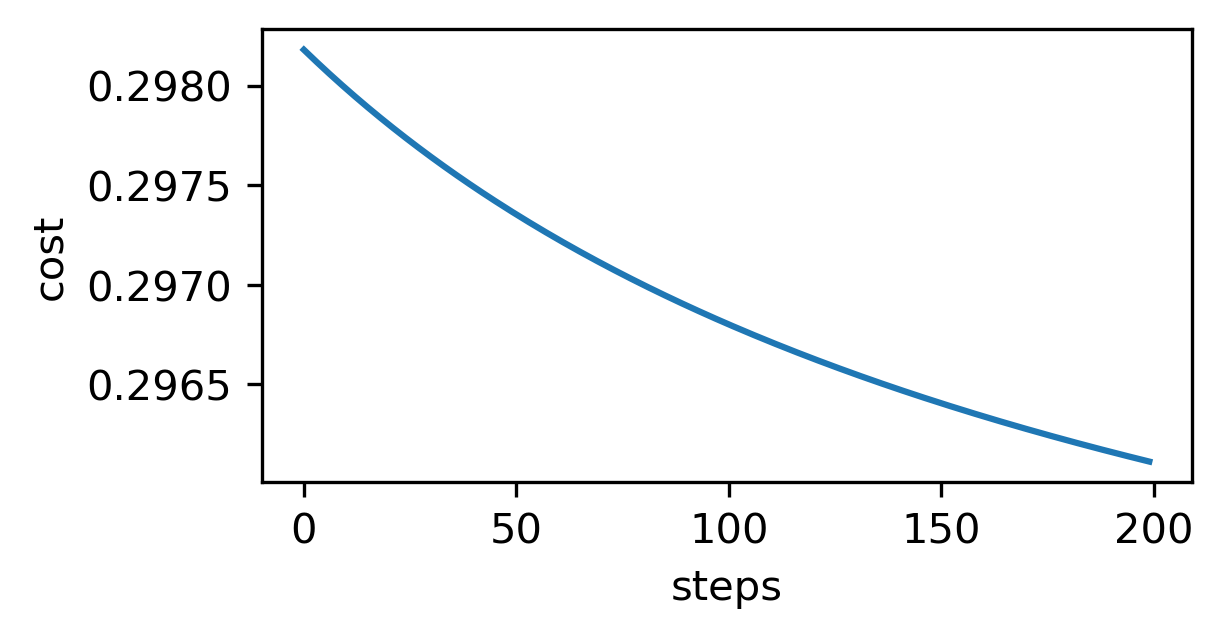

In [66]:
eta = 0.005
steps = 200

costs = np.zeros(steps)  # array to store the cost history

for k in range(steps):
    y_final, costs[k] = train_net(y_in, y_target, eta)
    verbose = 0   # to avoid tones of prints
    
plt.figure(figsize=(4,2))
plt.plot(costs)
plt.xlabel('steps')
plt.ylabel('cost')
plt.show()

Why this cost evolution is so smooth? 

### 2.3 Train a net on batches to fit a 2D function

Let's define a new NN model with a different 'shape'

In [95]:
# set up all the weights and biases
layerSizes = [2, 100, 1]  # input-layer,hidden-1,hidden-2,...,output-layer
batch_size = 128
init_model(layerSizes, batchsize=batch_size, rand_lim=0.1, zero_bias=True)
print_model()

 
Weights: 
 - shapes: (2, 100) x (100, 1)
 - maxs: 0.09958352090588038 ; 0.09618043921624717
 - mins: -0.09851716266483537 ; -0.09895971619961151
 
Biases: 
 - shapes: (100,) x (1,)
 - maxs: 0.0 ; 0.0
 - mins: 0.0 ; 0.0
 
dw_layer: 
 - shapes: (2, 100) x (100, 1)
 - maxs: 0.0 ; 0.0
 - mins: 0.0 ; 0.0
 
db_layer: 
 - shapes: (100,) x (1,)
 - maxs: 0.0 ; 0.0
 - mins: 0.0 ; 0.0
 
y_layer: 
 - shapes: (128, 2) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
df_layer: 
 - shapes: (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0
 - mins: 0.0 ; 0.0


Just for fun: Let's set up rectified linear units (relu) as activation function, instead of sigmoid

In [68]:
def net_f_df(z):  # calculate f(z) and f'(z)
    val = z * (z>0)
    return val, z>0  # return both f and f'

Let's define a certain 2D function to be fitted

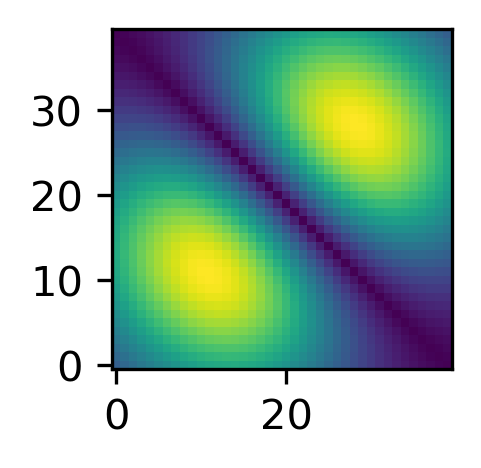

In [69]:
def myFunc(x0,x1):
    """ Target function to be fitted. It expects any range for x0 and x1
    """
    r2 = x0**2+x1**2
    return np.exp(-5*r2)*abs(x1+x0)

Npixels = 40  # The resolution of our 2D target function
xrange = np.linspace(-0.5, 0.5, Npixels)  #Let's explore the (-0.5, 0.5) range

X0, X1 = np.meshgrid(xrange, xrange)

plt.figure(figsize=(1.5,1.5))
plt.imshow(myFunc(X0,X1), interpolation='nearest', origin='lower')
plt.show()

Let's define a function to get a `batchsize` number of representations for the target function within a range. Similar to the `samples` and `get_ground_truth` functions on the 'Curve fitting' section, at once.

In [70]:
def make_batch(batchsize, inputs):  # low=-0.5, high=+0.5):
   
    # sample = uniform(low=low, high=high, size=[batchsize, 2])
    
    sample = np.zeros((batch_size, )+(len(inputs),))
    for idx in range(len(inputs)):
        sample[:, idx] = np.random.choice(inputs[idx].flatten(), batch_size)

    
    targets = np.zeros([batchsize, 1])  # must have right dimensions
    targets[:,0] = myFunc(sample[:,0], sample[:,1])
    
    return sample, targets

In [71]:
def show_batch_in_image(batch_inp, batch_out, x_map, y_map,
                        bkgrnd=0, transpose=False):
    batch_im = np.ones([x_map.size, y_map.size])*bkgrnd

    for el_inp, el_out in zip(batch_inp, batch_out):
        idx_x = (np.abs(x_map - el_inp[0])).argmin()
        idx_y = (np.abs(y_map - el_inp[1])).argmin()

        batch_im[idx_x, idx_y] = el_out

    batch_im = batch_im.T if transpose else batch_im
    plt.figure(figsize=(1.5,1.5))
    plt.imshow(batch_im, origin='lower')        
    plt.title('Batch on the image')

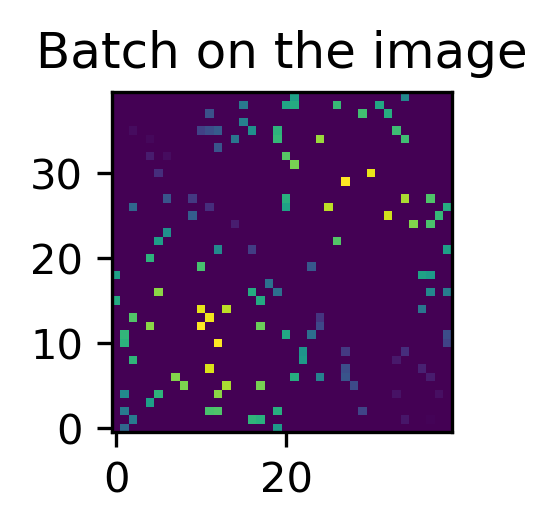

In [90]:
show_batch_in_image(*make_batch(batch_size, (X0[0,:], X1[:,0])), X0[0,:], X1[:,0])

Let's define a function to evaluate the training, this is by testing the whole function scope

In [91]:
def get_test_samples(sample_range):
    """ Returns an array containing all xy-pairs on the sample_range
    """
    X0, X1 = np.meshgrid(sample_range, sample_range)
    
    full_batch = np.shape(X0)[0]*np.shape(X0)[1]
    testsample = np.zeros([full_batch,2])
    testsample[:,0] = X0.flatten()
    testsample[:,1] = X1.flatten()
    
    return testsample  # batch_size x 2 array with all xy values on the plane

In [92]:
def evaluate_current_state(samples, ax=None):
    """ Evaluate the network on some area in the 2D plane defined by samples
    """
    ax = plt.gca() if ax == None else ax  # to plot on a certain axes (optional)
    
    global weights, biases, n_layers  # loading current NN state

    testoutput = apply_net_simple(samples)  # applying the NN to the input set
    
    ax.imshow(np.reshape(testoutput,np.shape(X0)), origin='lower')
    ax.set_title("Current network prediction", fontsize=6)

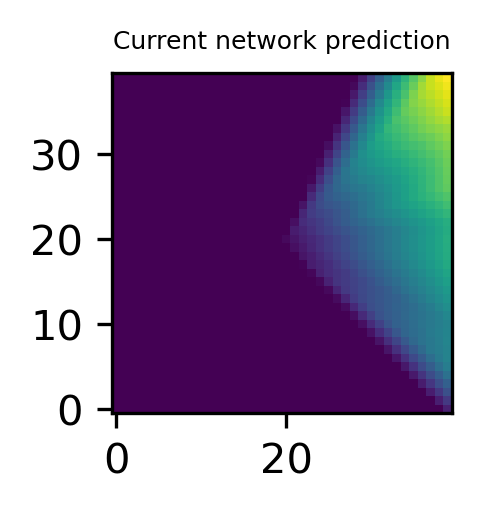

In [96]:
plt.figure(figsize=(1.5,1.5))
testsample = get_test_samples(xrange)
evaluate_current_state(testsample)

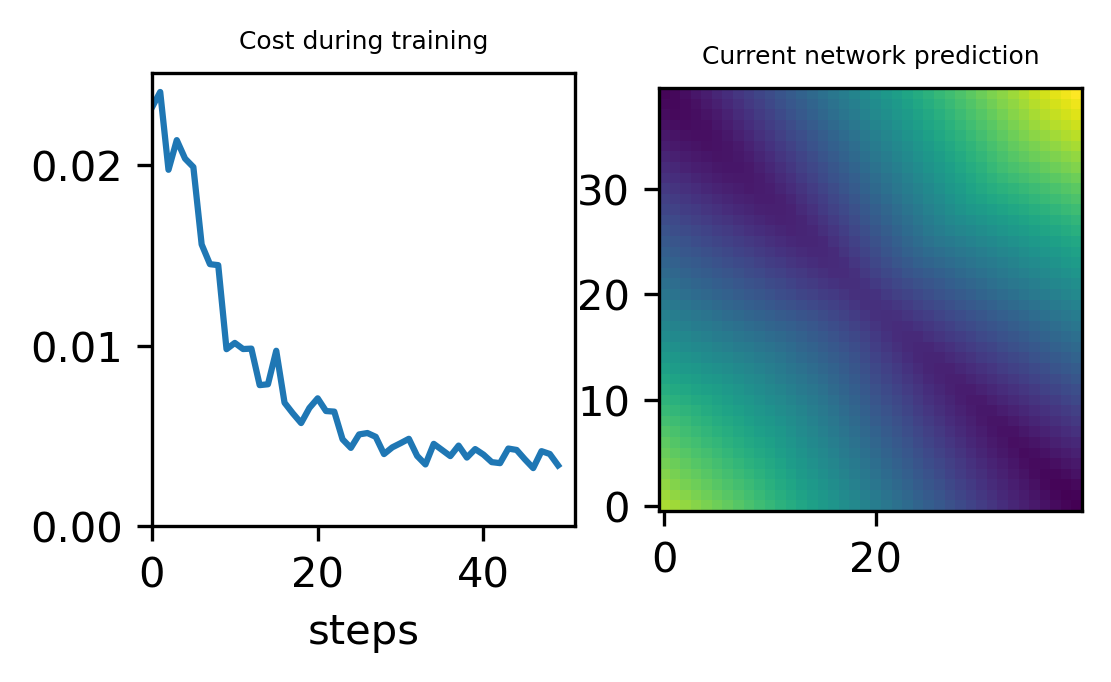

In [97]:
eta = 0.05   # learning rate
nsteps = 51  # number of training steps

costs = np.zeros(nsteps)  # let's store the cost history
for j in range(nsteps):
    clear_output(wait=True)
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(4,2))  # prepare figure
    sleep(2)
    # random sample the target function to get a training set
    y_in, y_target = make_batch(batch_size, (X0, X1))
    
    # training the NN with the training set
    y_final, costs[j] = train_net(y_in, y_target, eta)  # this is just one step
    
    # NN validation using the whole XY-plane
    evaluate_current_state(testsample, ax[1])  # testsample contains all XY-plane
   
    ax[0].plot(costs[:j])
    ax[0].set_title("Cost during training", fontsize=6)
    ax[0].set_xlabel("steps")
    ax[0].set_xlim(0, nsteps)
    ax[0].set_ylim(0)
    
    plt.show()

Why `y_final` is not used to check if training is going well? At the end of the day, it is the final state of our NN model. We use `testsample` instead.

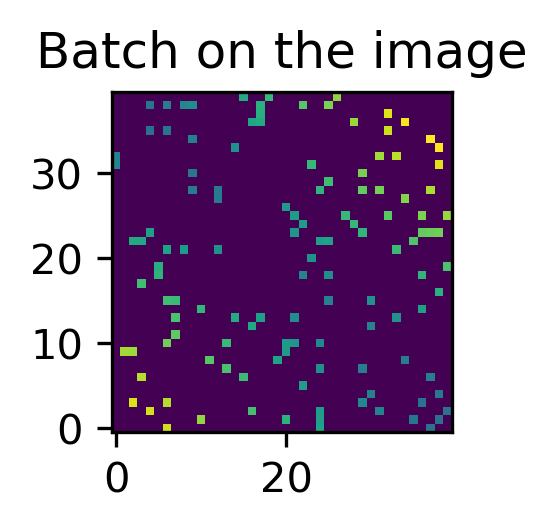

In [98]:
show_batch_in_image(y_in, y_final, X0[0,:], X1[:,0])

## 3. Train a net to reproduce an image

### 3.1 Taking an image and converting it to a function

In [99]:
import imageio

# load the pixel image
face = imageio.imread('data/Smiley.png')
pixel_image = np.transpose(face[:,:,0])  # have to transpose...
pixel_image = pixel_image[:,::-1]  # and flip... to get the right view!

# normalize between 0 and 1
pixel_image -= pixel_image.min()
pixel_image = (pixel_image.astype(dtype='float'))/pixel_image.max()

image_size = np.shape(pixel_image)[0] # assuming a square image!
print(pixel_image.shape)

(194, 194)


Ok, we have an image, but we are used to deal with functions (like in the sections above).

Let's override the `myFunc` function in order to return the value of a certain point on the image

In [100]:
def myFunc(x0, x1):
    """ The function we want to have (desired outcome)
        this picks the pixels from the image of a given position
    """
    global pixel_image, image_size  # this is to preserve the function signature
    
    # convert coordinates to index (assuming input like 0..1)
    idx_x = (x0*image_size*0.9999).astype(dtype='int')
    idx_y = (x1*image_size*0.9999).astype(dtype='int')
    
    return pixel_image[idx_x, idx_y]  # extract the values at these pixels


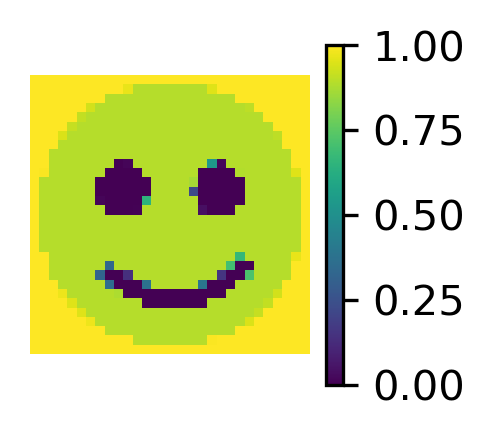

In [101]:
Npixels = 30  # let's do it on a low-res grid! (saves time)
xrange = np.linspace(0, 1, Npixels)
X0, X1 = np.meshgrid(xrange,xrange)

plt.figure(figsize=(1.5, 1.5))
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower')
plt.axis('off')
plt.colorbar()
plt.show()

### 3.2 Batches generator

The importance of the batch size

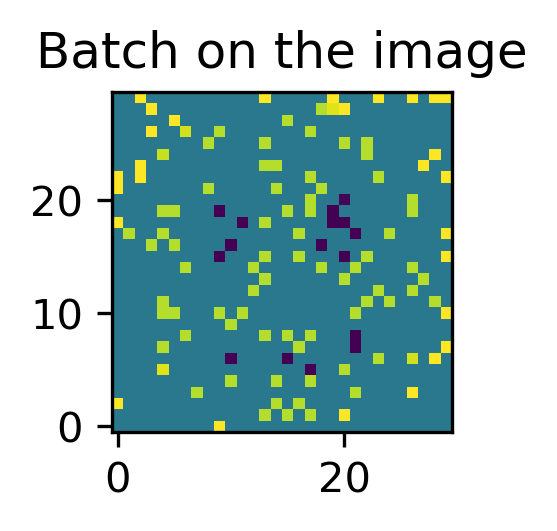

In [133]:
batch_size = 128

show_batch_in_image(*make_batch(batch_size, (X0[0,:], X1[:,0])), 
                    X0[0,:], X1[:,0], bkgrnd=0.4, transpose=True)

### 3.3 Model initialization

In [124]:
# set up all the weights and biases
layerSizes = [2, 150, 100, 1]  # input-layer,hidden-1,hidden-2,...,output-layer
# batch_size = 128  # is defined above with some criteria
init_model(layerSizes, batchsize=batch_size, rand_lim=5, 
           norm_weights=True, zero_bias=True)  # Check init. parameters links
print_model()

 
Weights: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 11.697581309754035 ; 1.8227288081297357 ; 1.2757673942875707
 - mins: -9.967753657014898 ; -1.6542613584980805 ; -0.7378591685616437
 
Biases: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
dw_layer: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
db_layer: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
y_layer: 
 - shapes: (128, 2) x (128, 150) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0 ; 0.0
 
df_layer: 
 - shapes: (128, 150) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0


Let's go back to the sigmoid. You can try with different activation functions

In [125]:
def net_f_df(z):  # calculate f(z) and f'(z)
    val = 1/(1+np.exp(-z))  # sigmoid
    return val, np.exp(-z)*(val**2)  # return both f and f'

Let's check the NN response

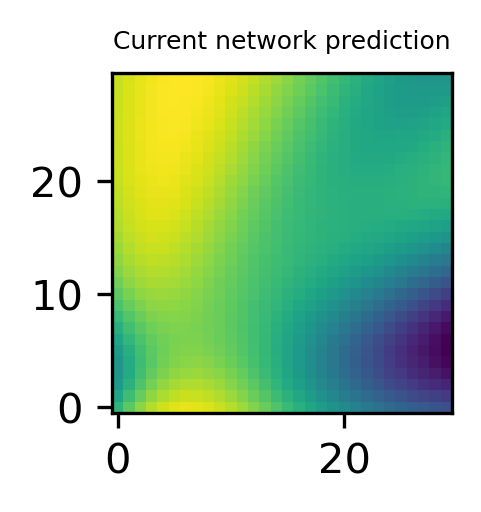

In [126]:
plt.figure(figsize=(1.5,1.5))
testsample = get_test_samples(xrange)
evaluate_current_state(testsample)

### 3.4 Model training

In [127]:
samples_count=0

In [128]:
# parameters
eta = 0.01
nsteps = 100000
nskip_steps = 100
do_savefig = False  # False to save time, True to make a GIF animation.
root_figure_filename = f"02_smiley_{nsteps//1000}kSteps_{batch_size}bs"

costs = np.zeros(nsteps)
t0 = time()
for j in range(nsteps):
    
    y_in, y_target = make_batch(batch_size, (X0[0,:], X1[:,0]))
    y_out_result, costs[j] = train_net(y_in, y_target, eta)
    samples_count += batch_size
    testoutput = apply_net_simple(testsample)
    
    
    if j % nskip_steps == 0:  # time to plot again!
        clear_output(wait=True)
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
        test_image = np.reshape(testoutput, np.shape(X0))
        img = ax[1].imshow(test_image, origin='lower', interpolation='nearest', 
                           vmin=0, vmax=1)
        ax[1].set_title(f"{j} steps done ; {samples_count} samples used")
        ax[1].axis('off')
        ax[0].plot(costs[:j+1])
        ax[0].set_xlabel("Steps done")
        ax[0].set_ylabel("Cost")
        ax[0].set_xlim(0, nsteps)
        fig.suptitle(f"Elapsed time: {(time() - t0) / 60:.0f} min", x=0.73, y=0.12)
        if do_savefig and j % (nskip_steps*10) == 0 :  # To save time
            plt.savefig("data/" + root_figure_filename + f"_{j//nskip_steps}.png")
        plt.show()

KeyboardInterrupt: 

In [ ]:
# This is totally optional!! It creates a GIF animation 
#  from the saved images during the training above (do_savefig must be True).
#  Just to show the evolution
from PIL import Image

images2 = []
for n in range(100):
    filename = "data/" + root_figure_filename + f"_{n*10}.png"
    frame = Image.open(filename)
    images2.append(frame)

    
images2[0].save('resources/' + root_figure_filename + '.gif',
                save_all=True,
                append_images=images2[1:],
                duration=5,
                loop=50)

for n in range(100):
    filename = "data/" + root_figure_filename + f"_{n*10}.png"
    os.remove(filename)

**Training evolution for 100,000 steps and `batchsize=128` (12,800,000 evaluated samples) it takes about 30min:**

<img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/02_smiley_100kSteps_128bs.gif"
 alt="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/02_smiley_100kSteps_128bs.gif">

You need about some millions of samples to get something reasonable looking, with this hyperparameters.

Compare the total samples used with the number of pixels in the image. How many times is every pixel re-evaluated, in average?

    epochs = total_samples / total_pixels = (n_steps * batch_size) / (pixel_size * pixel_size) = 14222

#### [EXERCISE]: find better hyper-parameters  like learning rate and/or batchsize to reduce the number of samples and/or time needed (look on the exercise below to do both at once).

### Save and load a model

In [ ]:
filename = "data/02_Network_Smiley.npz"

print("Do you want to save your current model? [yes/NO]")
print(f"Be careful! If you type 'Yes', it will overwrite the '{filename}' file !!")
sleep(0.5)  # This is to save the order of prints
save_model = input().lower() in ('yes', 'y')

if save_model:  # save the resulting network
    """ https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html
    """
    np.savez_compressed(filename, 
                        layerSizes=np.array(layerSizes),  # it save anly np objects
                        weights=weights, biases=biases)
    filesize_KB = os.path.getsize(filename) / 1000
    print(f'Saved! The file size is {filesize_KB}KB')
else:
    print('aborted')
    

Compare the npz file-size with the image file-size.

#### 3.4.4 [EXERCISE]: find better hyper parameters for layerSizes to reduce the network model size, i.e. the 02_Network_Smiley.npy size in KB, keeping a reasonable good looking of the image.

Let's see how we can recover a whole neural network model and state.

Just an initialized model:
 
Weights: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 0.9890639272541946 ; 0.9996787733302419 ; 0.945538207904133
 - mins: -0.9986781076945812 ; -0.9998980367502373 ; -0.990829817953865
 
Biases: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.9892169107054412 ; 0.9992050943930171 ; -0.349733203521174
 - mins: -0.9995311637998063 ; -0.997281177296365 ; -0.349733203521174
 
dw_layer: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
db_layer: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
y_layer: 
 - shapes: (128, 2) x (128, 150) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0 ; 0.0
 
df_layer: 
 - shapes: (128, 150) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0


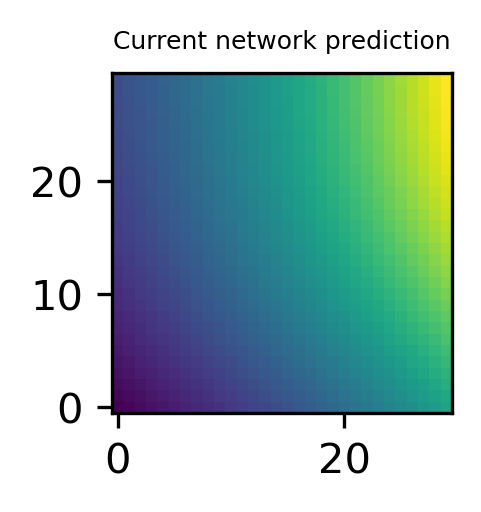

In [134]:
""" https://numpy.org/doc/stable/reference/generated/numpy.load.html
"""
data = np.load("data/02_Network_Smiley.npz", allow_pickle=True)

layerSizes = data['layerSizes']
init_model(layerSizes, batchsize=128)  # Why coould this be needed ??

print("Just an initialized model:")
print_model()
plt.figure(figsize=(1.5, 1.5))
evaluate_current_state(testsample)

weights = data['weights']
biases = data['biases']

Let's see what has been loaded

 
Weights: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 15.1163354401142 ; 3.213376059551101 ; 1.5187666724521858
 - mins: -9.37126204337695 ; -5.805381402716268 ; -1.973624260588141
 
Biases: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.055390985694704645 ; 0.004693457978618778 ; -0.013923263692330977
 - mins: -0.03504440635120845 ; -0.004424379730666998 ; -0.013923263692330977
 
dw_layer: 
 - shapes: (2, 150) x (150, 100) x (100, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
db_layer: 
 - shapes: (150,) x (100,) x (1,)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0
 
y_layer: 
 - shapes: (900, 2) x (128, 150) x (128, 100) x (128, 1)
 - maxs: 1.0 ; 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0 ; 0.0
 
df_layer: 
 - shapes: (128, 150) x (128, 100) x (128, 1)
 - maxs: 0.0 ; 0.0 ; 0.0
 - mins: 0.0 ; 0.0 ; 0.0


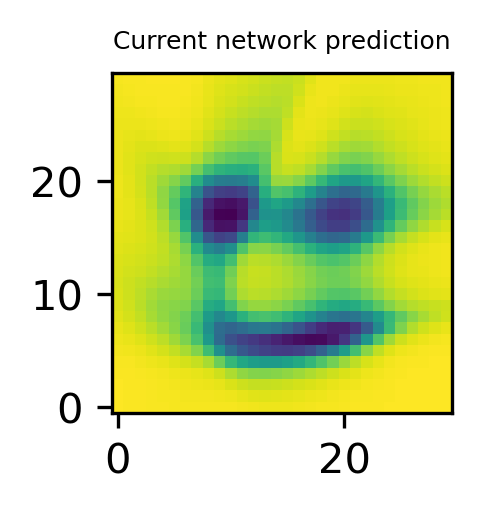

In [135]:
print_model()
plt.figure(figsize=(1.5,1.5))
evaluate_current_state(testsample)

### 3.6 Inside a network

Let's switch on only individual neurons of last hidden layer and plot the resulting pictures in a big 10x10 array.

In [136]:
lastWeights = weights[-1].copy()  # backup because we will modify weights below!

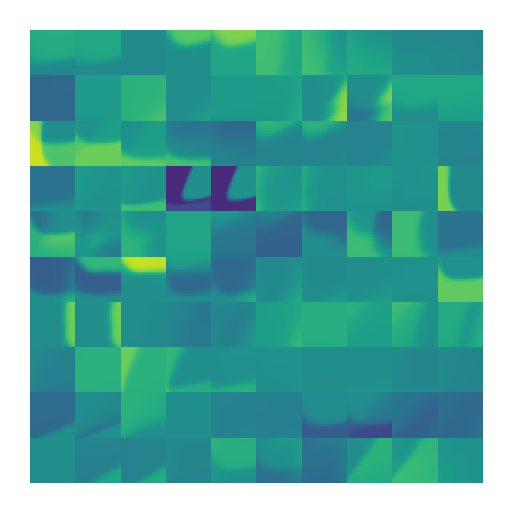

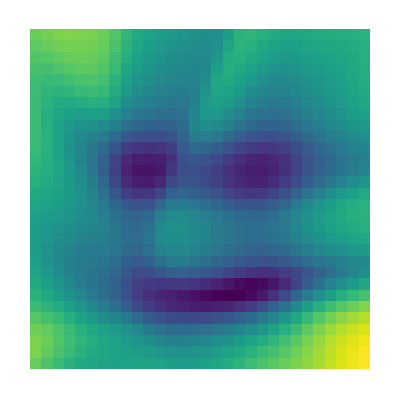

In [137]:
Nrow = 10
bigImage = np.zeros([Nrow*Npixels, Nrow*Npixels])
recovered = np.zeros([Npixels, Npixels])
for which in range(100):
    
    # let's set to zero all weiths exept for the output neuron under study
    weights[-1] = lastWeights.copy()
    weights[-1][0:which-1,:] = 0
    weights[-1][which+1:-1,:] = 0
    
    testoutput = apply_net_simple(testsample)
    
    samllImage = np.reshape(testoutput, np.shape(X0))
    
    row = int(which//Nrow)
    column = which%Nrow
    bigImage[Npixels*row:Npixels*(row+1),
             Npixels*column:Npixels*(column+1)] = samllImage
    
    recovered += samllImage
    

plt.figure(figsize=(2, 2))
plt.imshow(bigImage, origin='lower', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.show()
    
plt.figure(figsize=(1.5, 1.5))
plt.imshow(recovered, origin='lower', interpolation='nearest')
plt.axis('off')
plt.show()

## 4. Play with https://playground.tensorflow.org 